Import dependencies


In [ ]:
!pip install prettytable
!pip install pandas_profiling
!pip install pycaret

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from pycaret.classification import setup, compare_models


from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector


Read the dataset and understand its content


In [ ]:
df=pd.read_csv('CVD_cleaned.csv')

In [ ]:
df.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [ ]:
df.shape

(308854, 19)

In [ ]:
df.info()
#The info function displays information about the DataFrame, including data types and missing values.
#The data type has two values 'object' and 'float' so we can seperate the data into object and numeric columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

In [ ]:
df.describe()
#Generate summary statistics for numeric columns, the min and max, mean value, std etc...
#we can also see that the data is complete and we have no missing value

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


In [ ]:
## Splitting data into numerical and objective columns
numerical_data = df.select_dtypes(include=['float64'])
objective_data = df.select_dtypes(include=['object'])
print(objective_data.shape)
print(numerical_data.shape)
#creating 2 variables for numerical and objective columns
numerical=numerical_data.columns
objective=objective_data.columns
print(numerical)
print(objective)

(308854, 12)
(308854, 7)
Index(['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
       'Fruit_Consumption', 'Green_Vegetables_Consumption',
       'FriedPotato_Consumption'],
      dtype='object')
Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Smoking_History'],
      dtype='object')


In [ ]:
#The target variable in this data is Heart_Disease, the main idea of the notebook is to classify if the person has CVD based on
#different attributes

CVD='Heart_Disease'

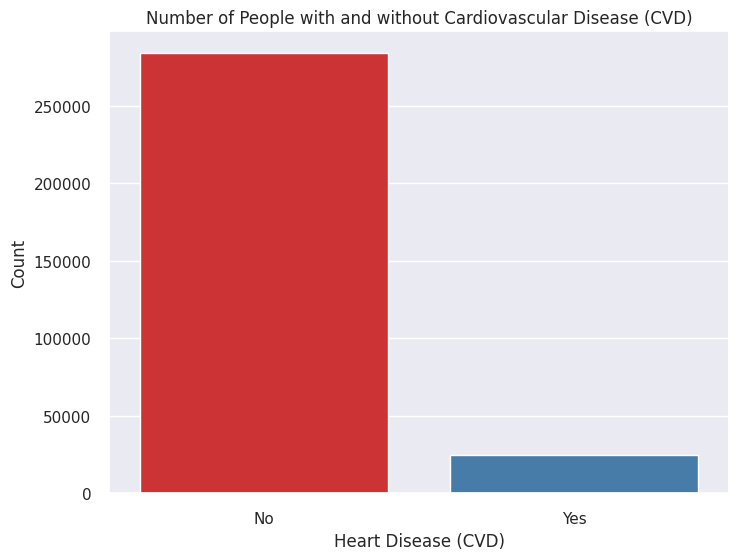

In [ ]:
# Create a countplot to visualize the number of people with and without CVD
sns.set(style="darkgrid")  # Set the style for the plot

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x=CVD, palette="Set1")

# Customize labels and title
plt.xlabel('Heart Disease (CVD)')
plt.ylabel('Count')
plt.title('Number of People with and without Cardiovascular Disease (CVD)')

# Show the plot
plt.show()

We can can see from the plot, that the data isn't balanced.

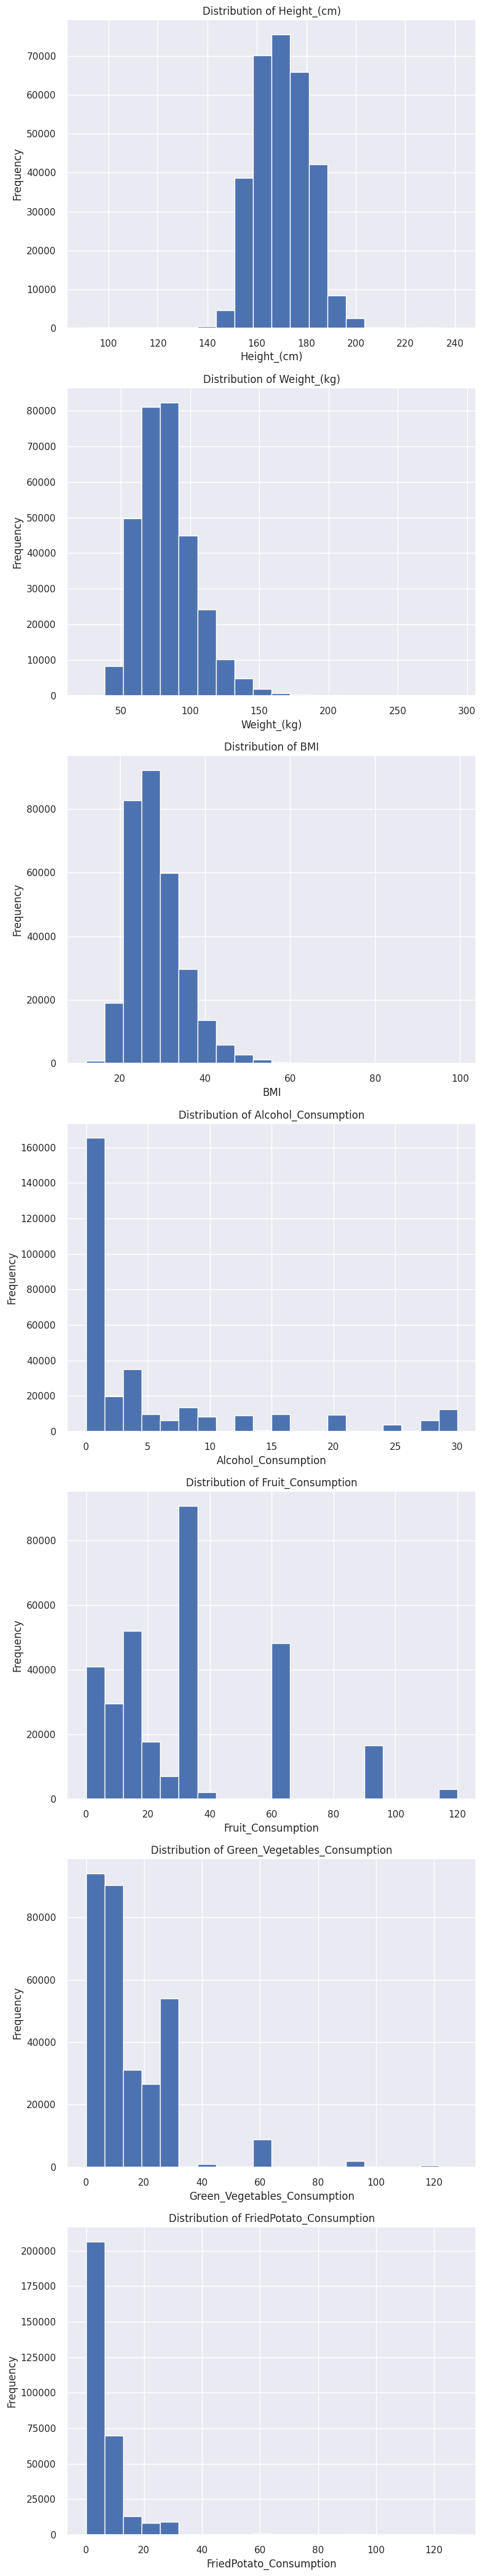

In [ ]:
#Plot the distribution of the numerical features
# Set up subplots
fig, axes = plt.subplots(nrows=len(numerical), ncols=1, figsize=(8, 6*len(numerical)))

# Iterate through columns and create histograms
for i, column in enumerate(numerical):
    ax = axes[i]
    df[column].plot(kind='hist', ax=ax, bins=20)  # Adjust the number of bins as needed
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout and display plots
plt.tight_layout()
plt.show()


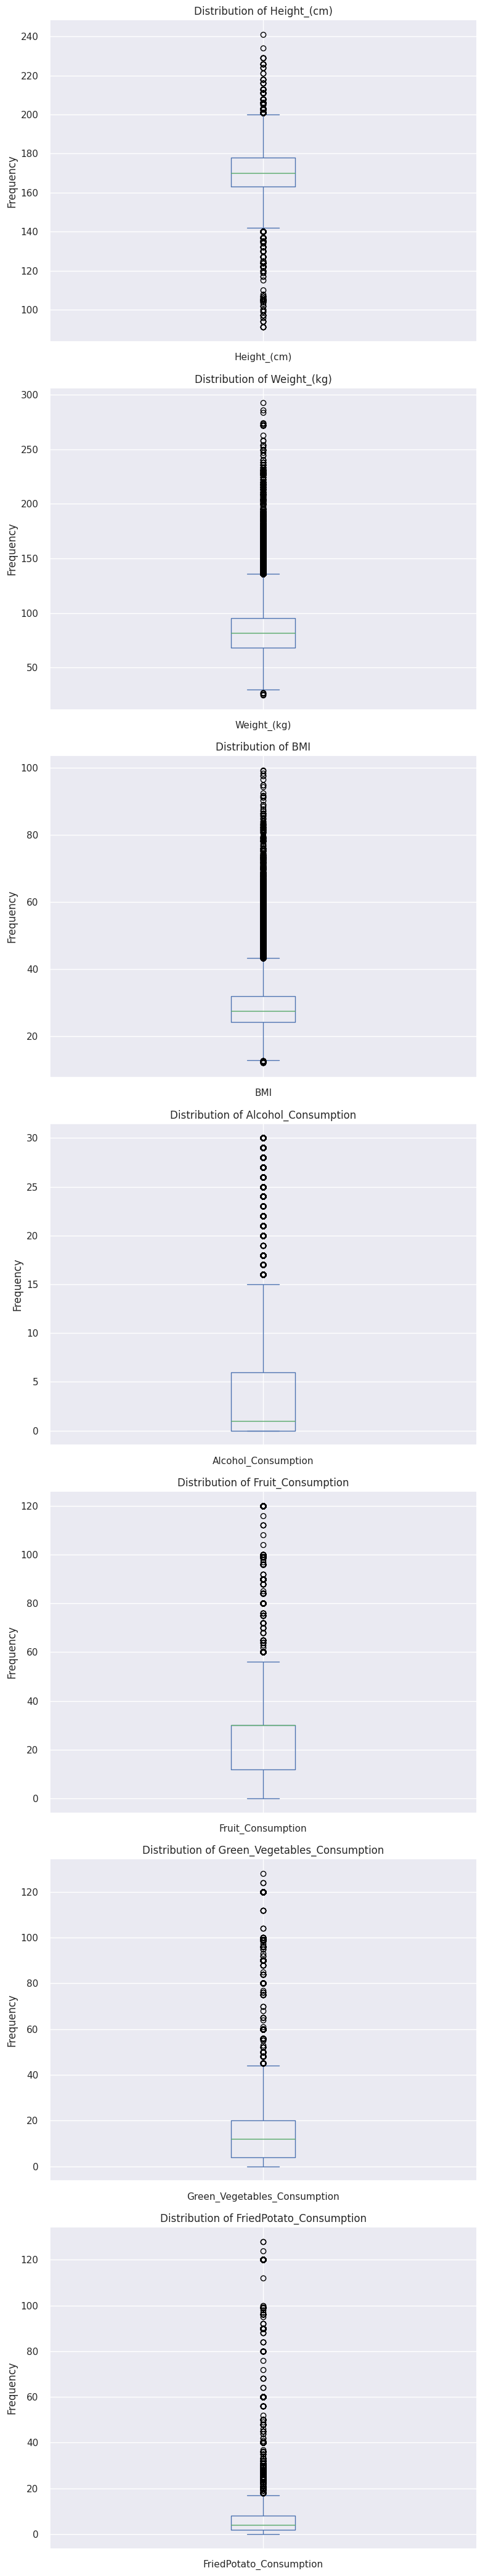

In [ ]:
#Plot the distribution of the numerical features
# Set up subplots
fig, axes = plt.subplots(nrows=len(numerical), ncols=1, figsize=(8, 6*len(numerical)))

# Iterate through columns and create histograms
for i, column in enumerate(numerical):
    ax = axes[i]
    df[column].plot(kind='box', ax=ax)  # Adjust the number of bins as needed
    ax.set_title(f'Distribution of {column}')
    ax.set_ylabel('Frequency')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

General_Health


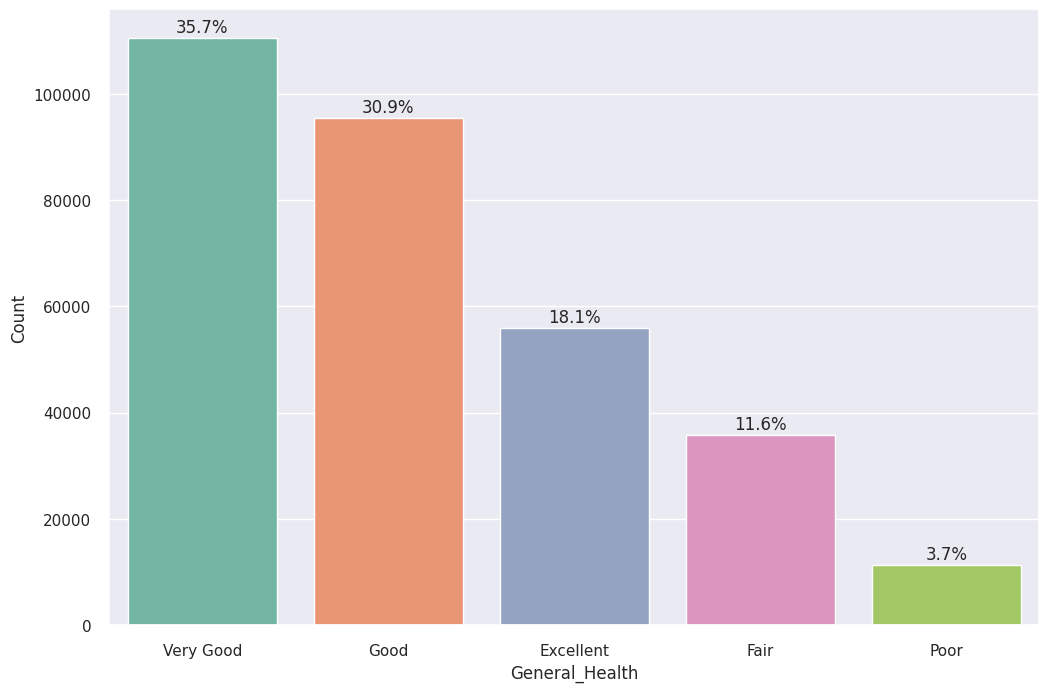

____________________________________________________________________________________________________________________________________________
Checkup


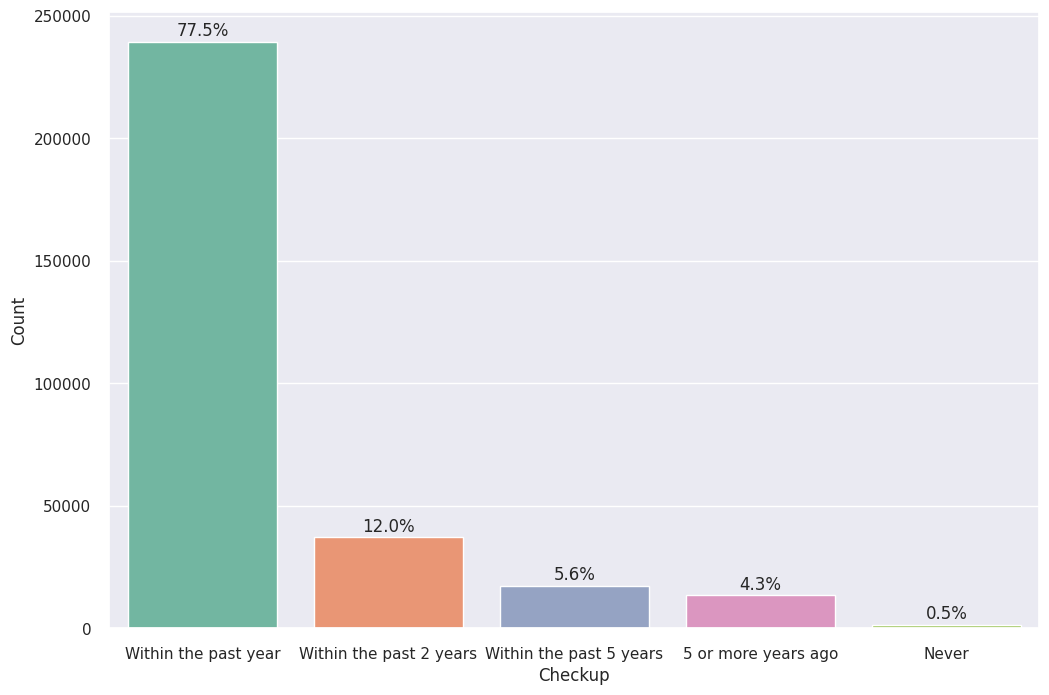

____________________________________________________________________________________________________________________________________________
Exercise


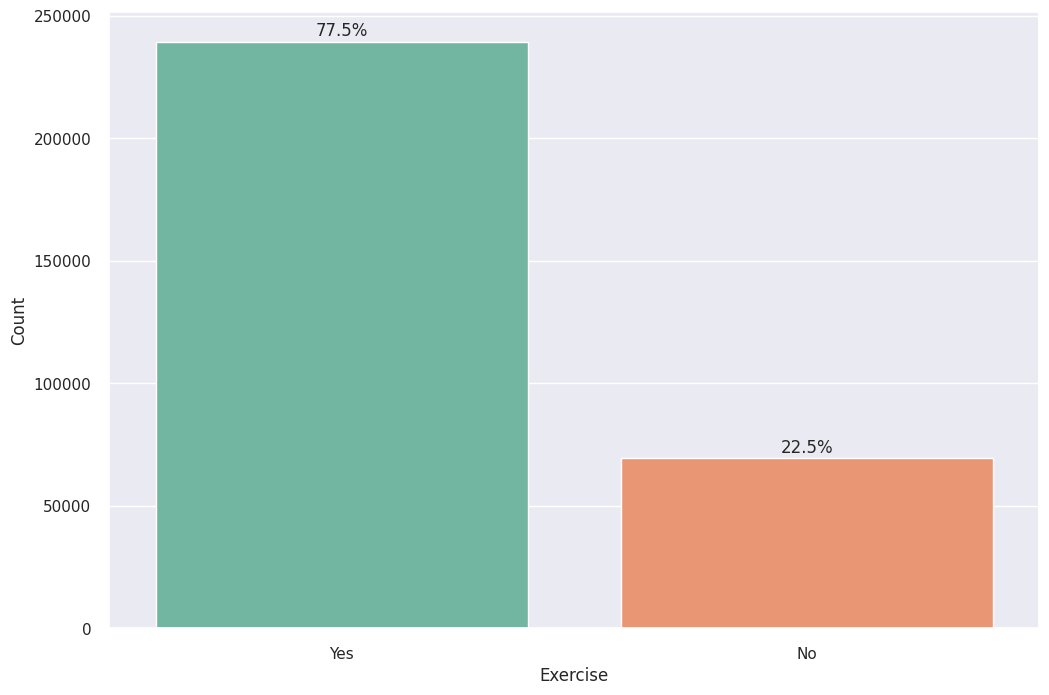

____________________________________________________________________________________________________________________________________________
Skin_Cancer


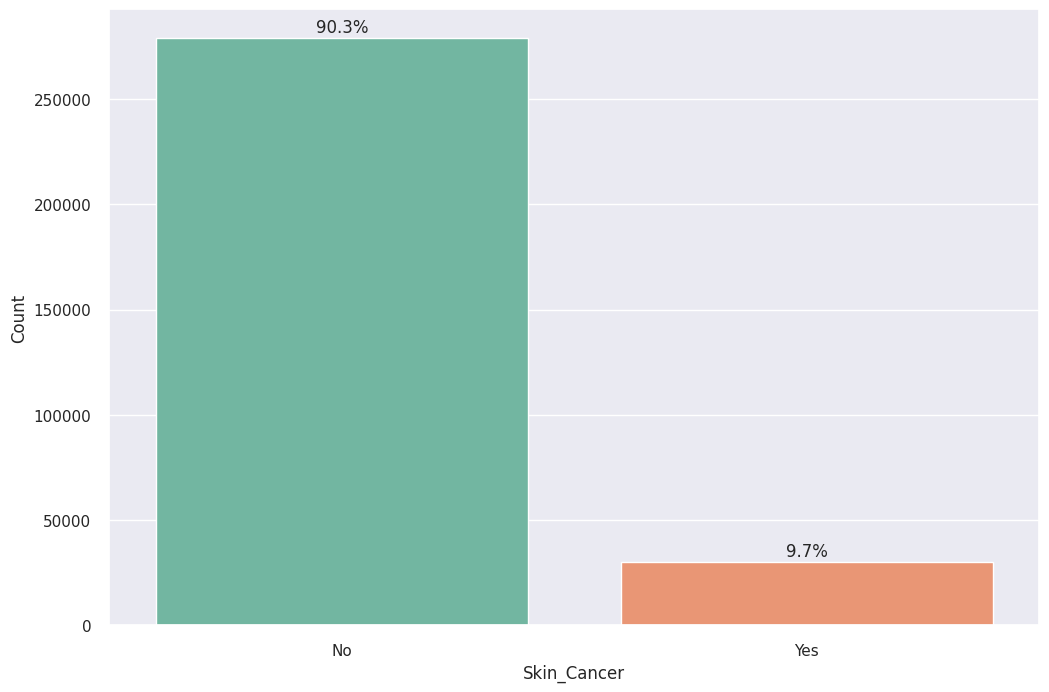

____________________________________________________________________________________________________________________________________________
Other_Cancer


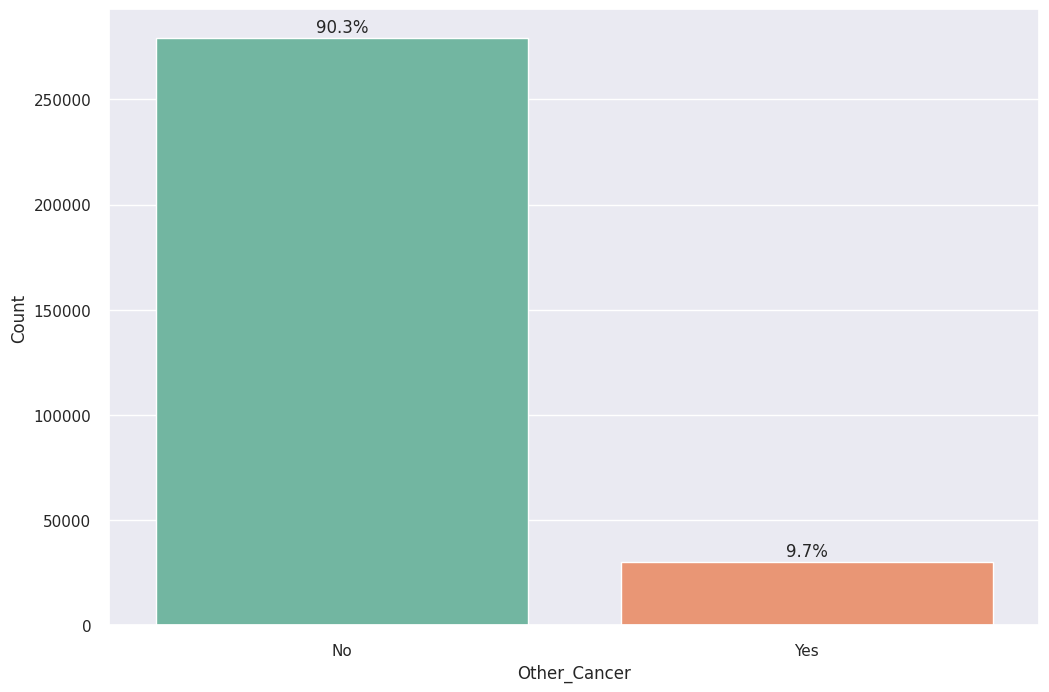

____________________________________________________________________________________________________________________________________________
Depression


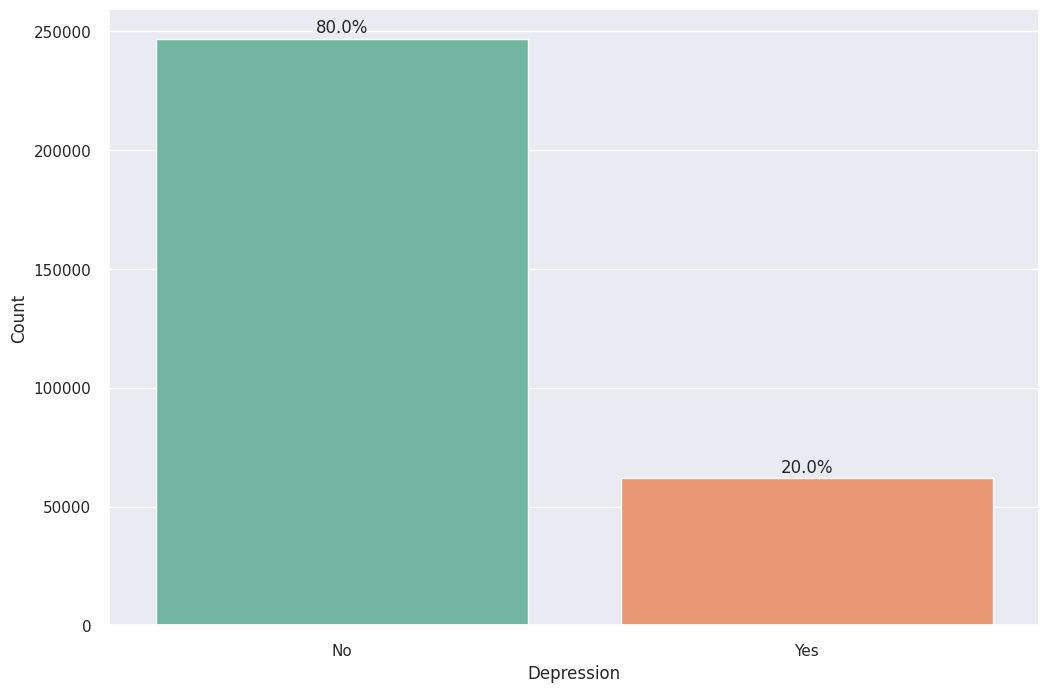

____________________________________________________________________________________________________________________________________________
Diabetes


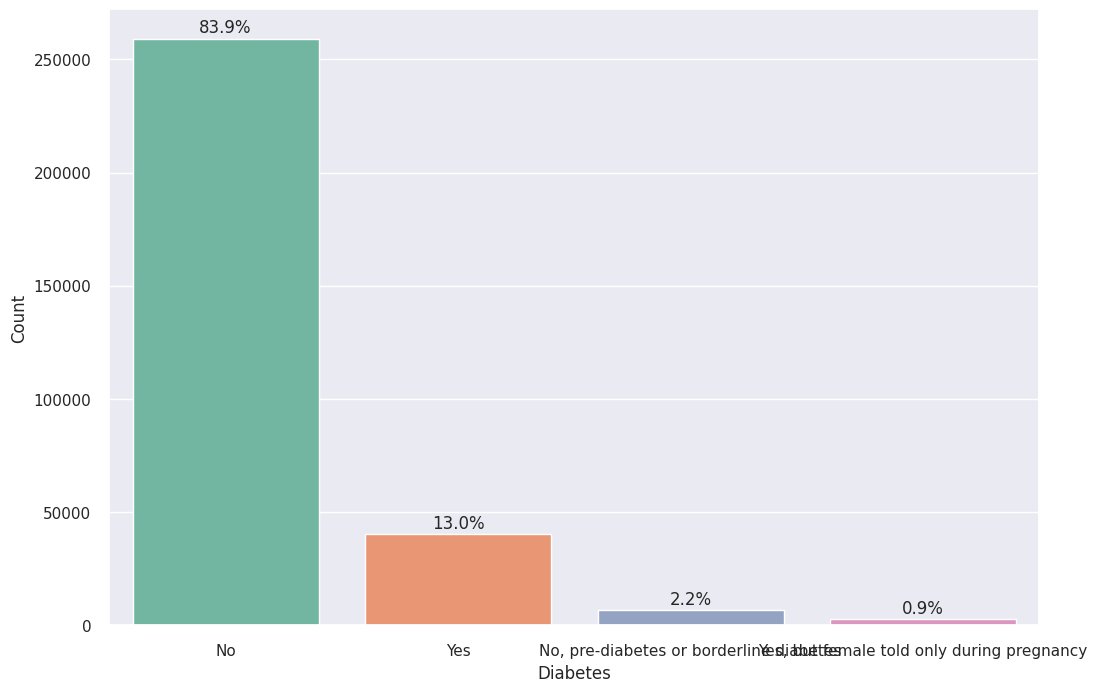

____________________________________________________________________________________________________________________________________________
Arthritis


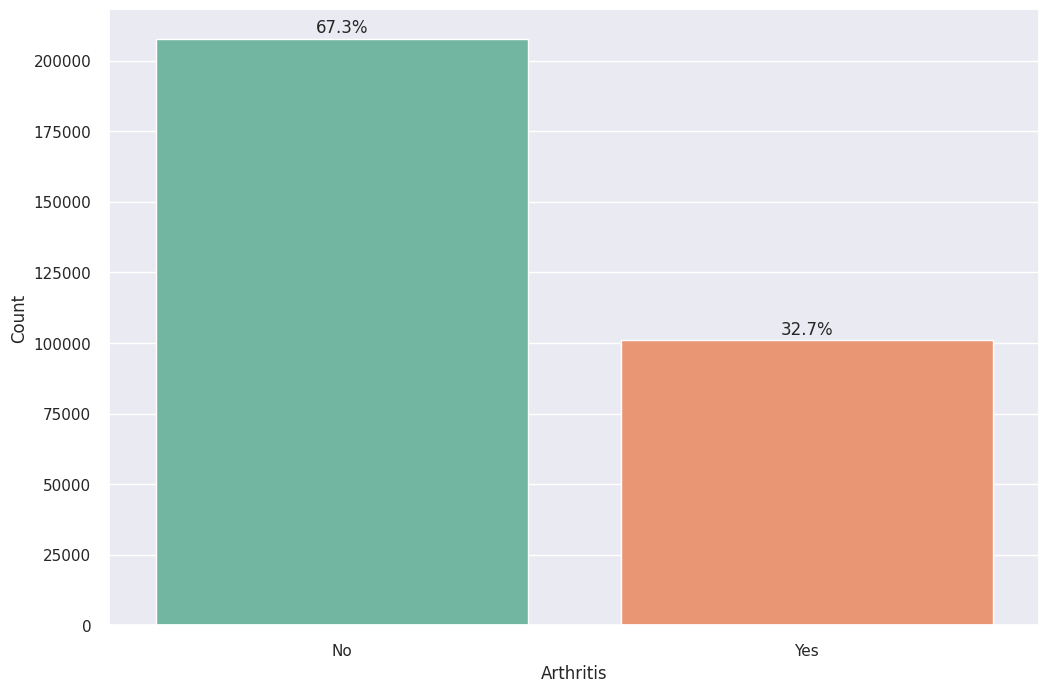

____________________________________________________________________________________________________________________________________________
Sex


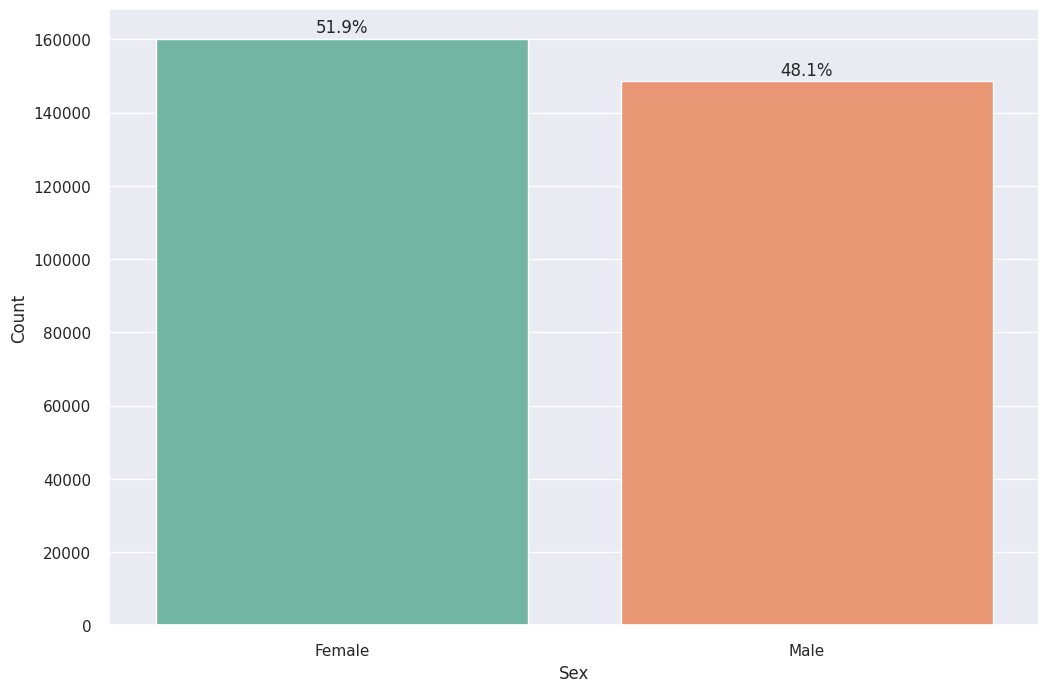

____________________________________________________________________________________________________________________________________________
Age_Category


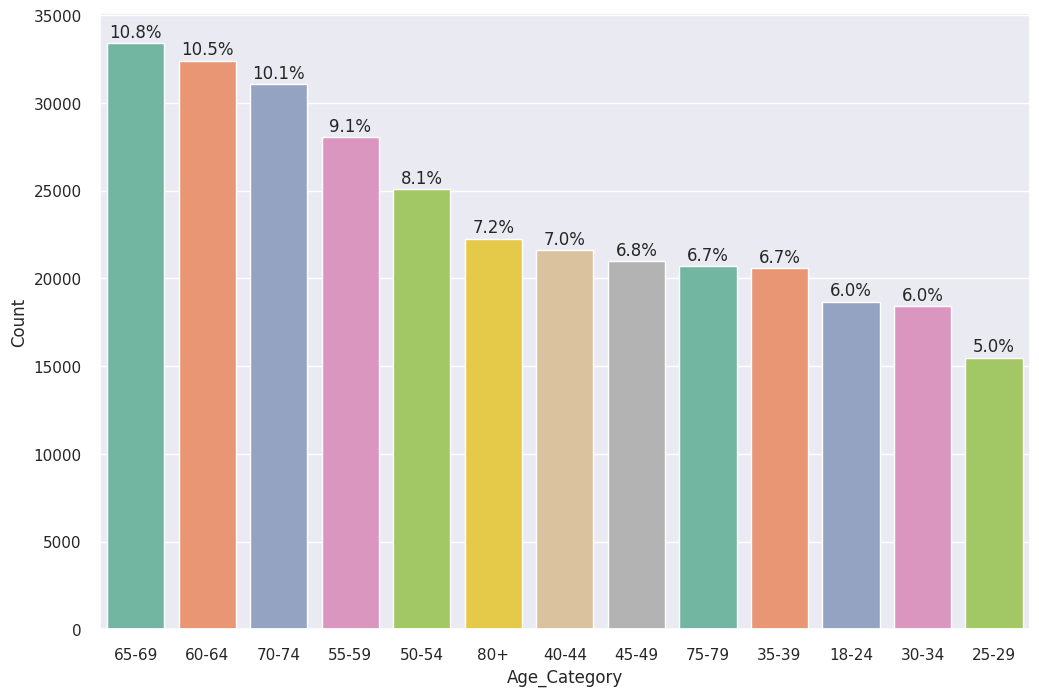

____________________________________________________________________________________________________________________________________________
Smoking_History


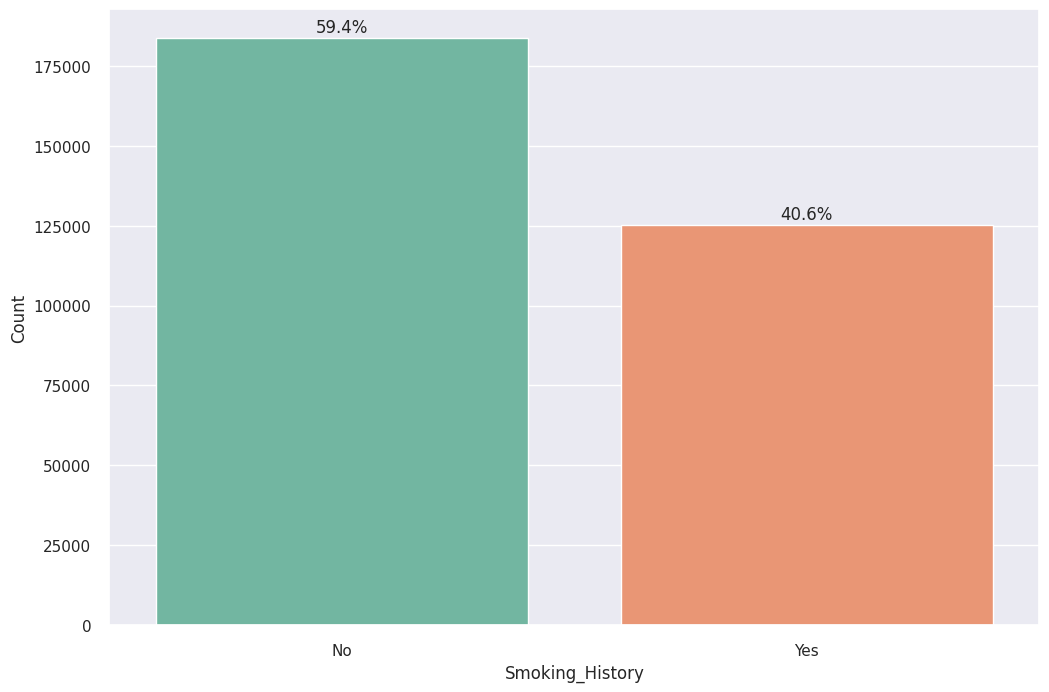

____________________________________________________________________________________________________________________________________________


In [ ]:
for i in df.columns:

    if i == CVD:
        continue

    if i in objective:
        if df[i].nunique() > 15:
            print(f'column {i} has many unique values n = {df[i].nunique()} and will not be plotted')
            print('________________________________________________________________________________________________________________________________________________________')
            continue
        else:
            print(f'{i}')
            fig,ax = plt.subplots(figsize = (12,8))
            color = 'Set2'
            palette_color = sns.color_palette(color)
            ax = sns.countplot(x = i,
                data=df,
                palette=color,
                order = df[i].value_counts().index
                )
            ax.set_ylabel('Count')
            patches = ax.patches

            for j in range(len(patches)):
                # list_unq_val = list(df[i].unique())

                # cleaned = [x for x in list_unq_val if str(x) != 'nan']
                offset = df[i].value_counts().max() * 0.01
                percentage = list(df[i].value_counts())[j]/df[i].value_counts().sum()
                x = patches[j].get_x() + patches[j].get_width()/2
                y = patches[j].get_height()+ offset
                ax.annotate('{:.1f}%'.format(percentage*100), (x, y), ha='center')

            plt.show()
            print('____________________________________________________________________________________________________________________________________________')

Now we would like to check the distribution of features with consideration of the target (which is with CVD or without)

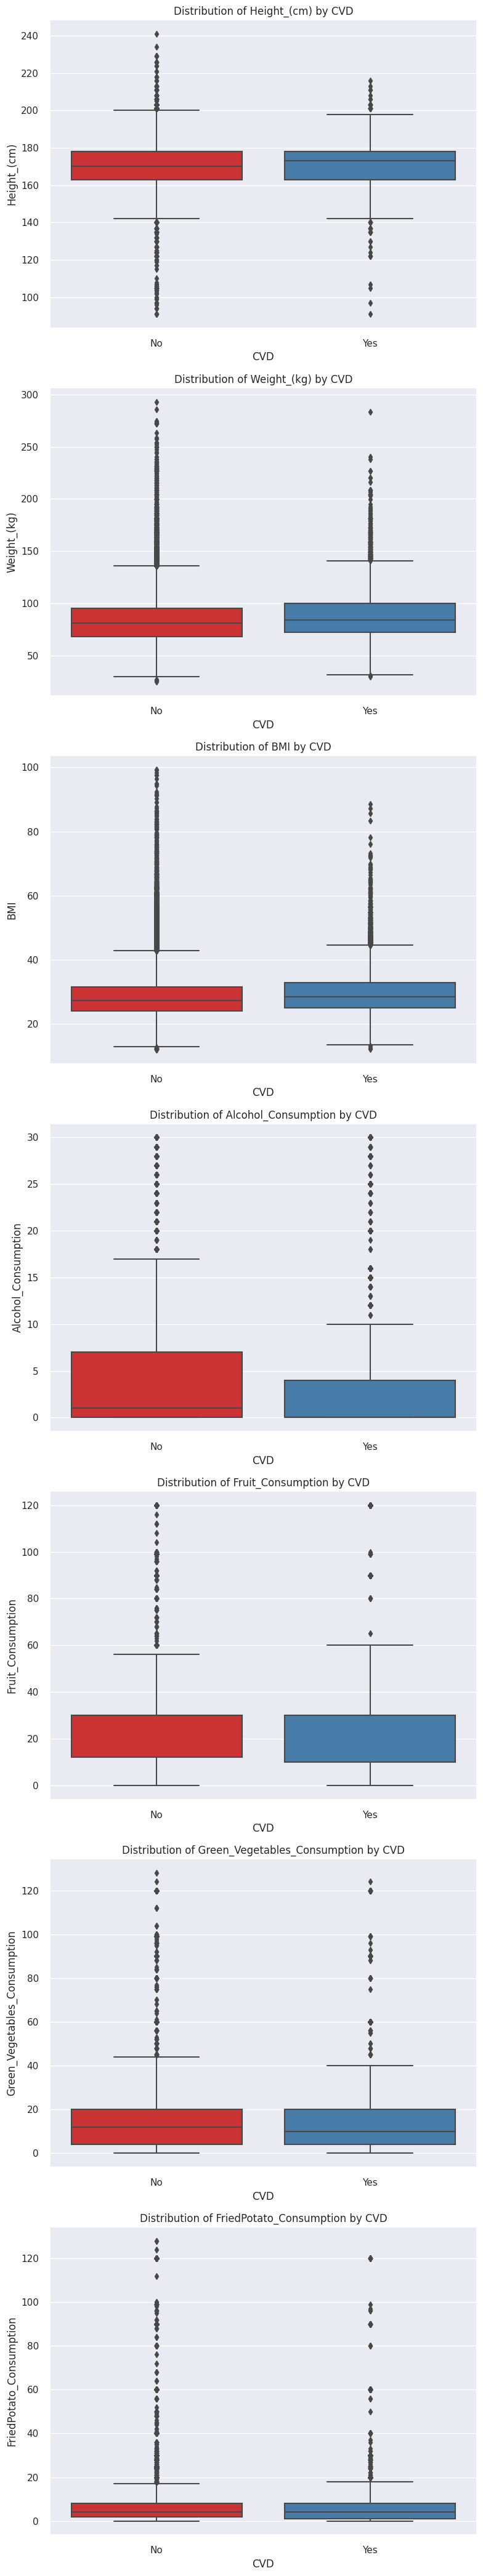

In [ ]:
# Set up subplots
fig, axes = plt.subplots(nrows=len(numerical), ncols=1, figsize=(8, 6*len(numerical)))

# Iterate through columns and create box plots for each feature with regards to the target
for i, column in enumerate(numerical):
    ax = axes[i]
    sns.boxplot(data=df, x=CVD, y=column, ax=ax, palette="Set1")
    ax.set_title(f'Distribution of {column} by CVD')
    ax.set_xlabel('CVD')
    ax.set_ylabel(column)

# Adjust layout and display plots
plt.tight_layout()
plt.show()


General_Health


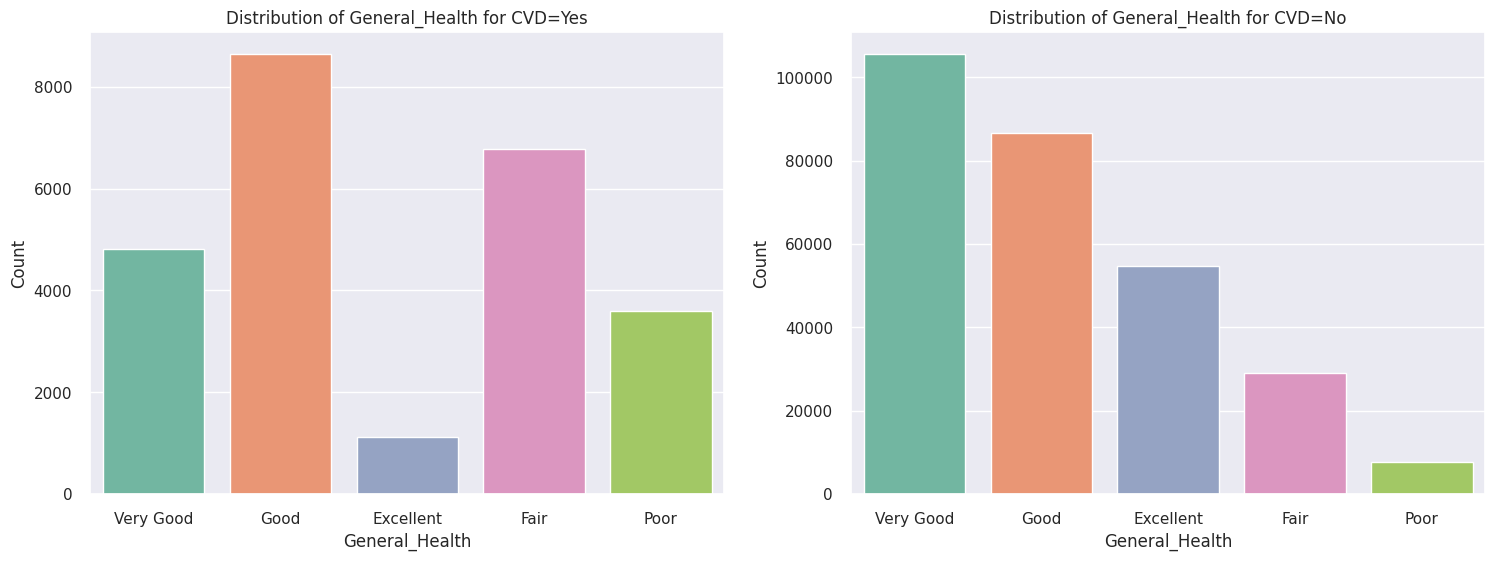

Checkup


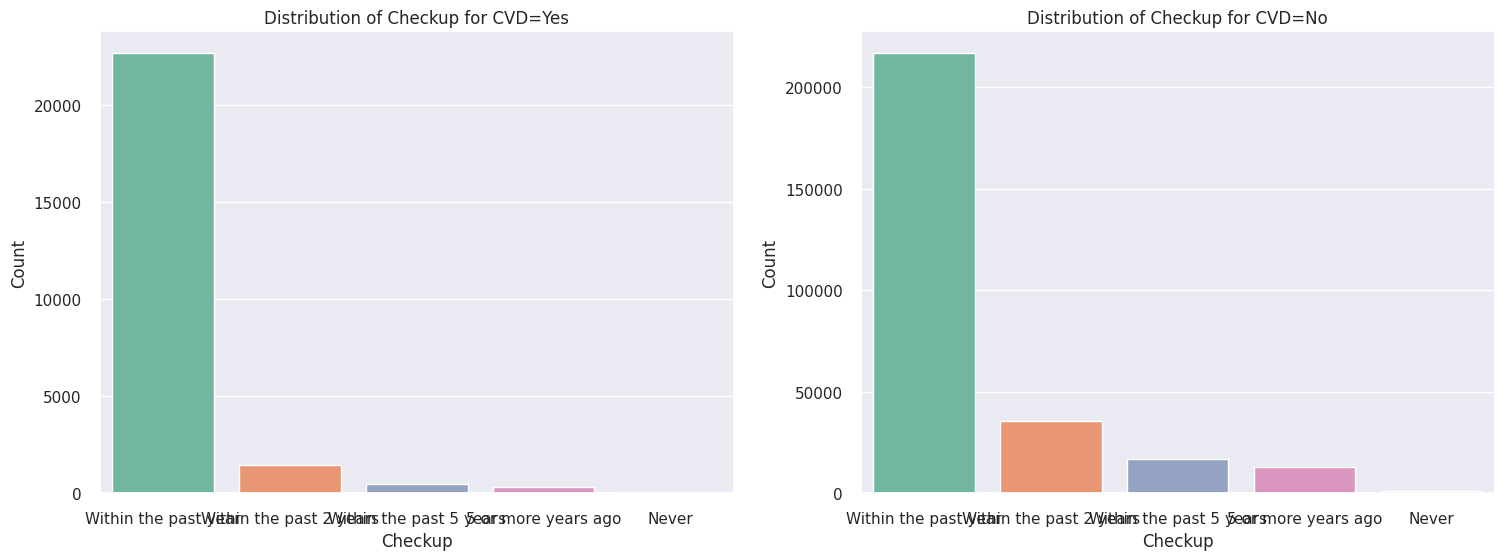

Exercise


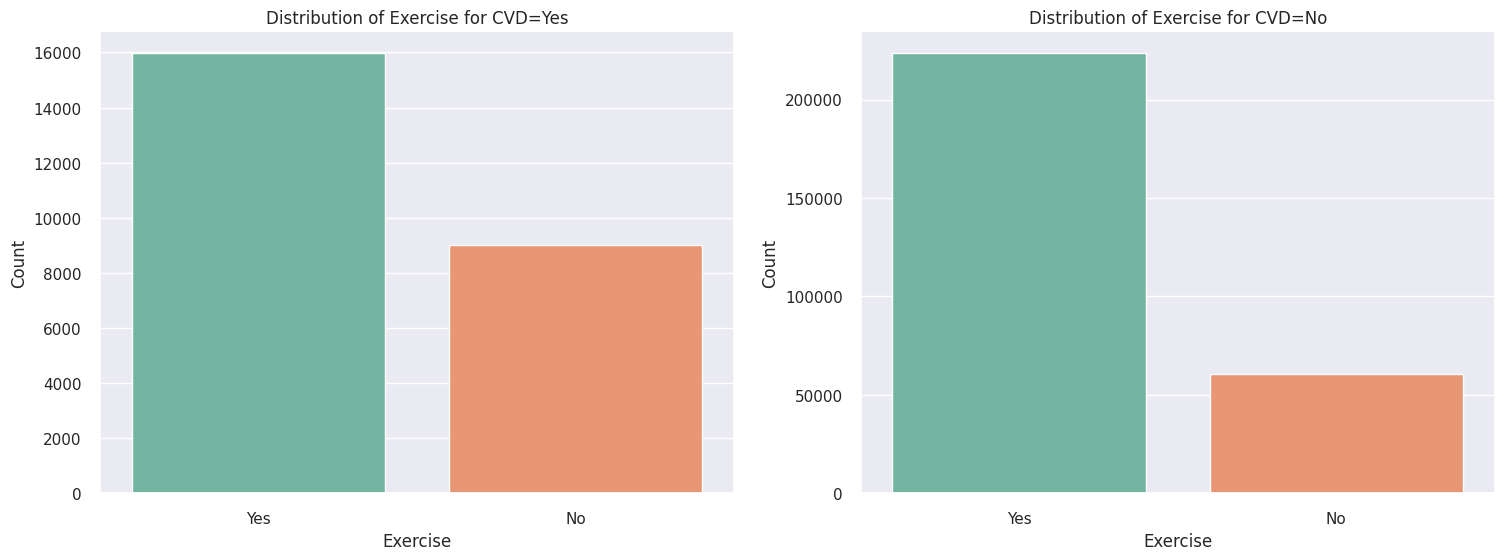

Skin_Cancer


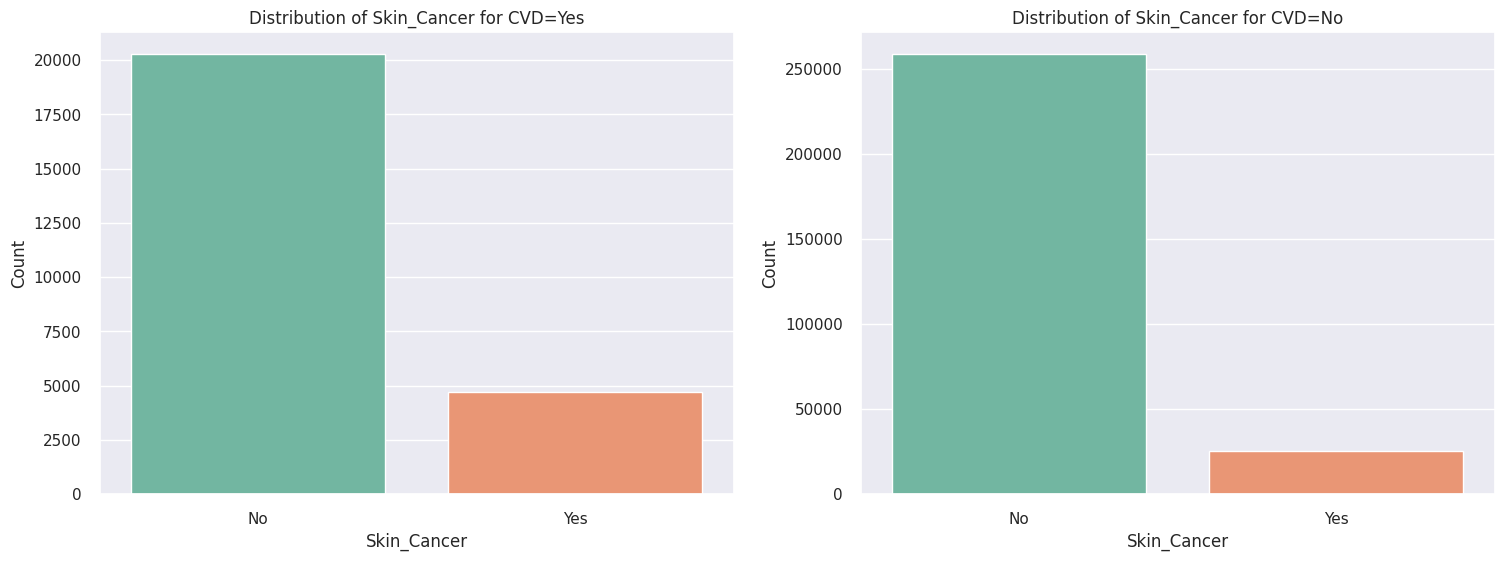

Other_Cancer


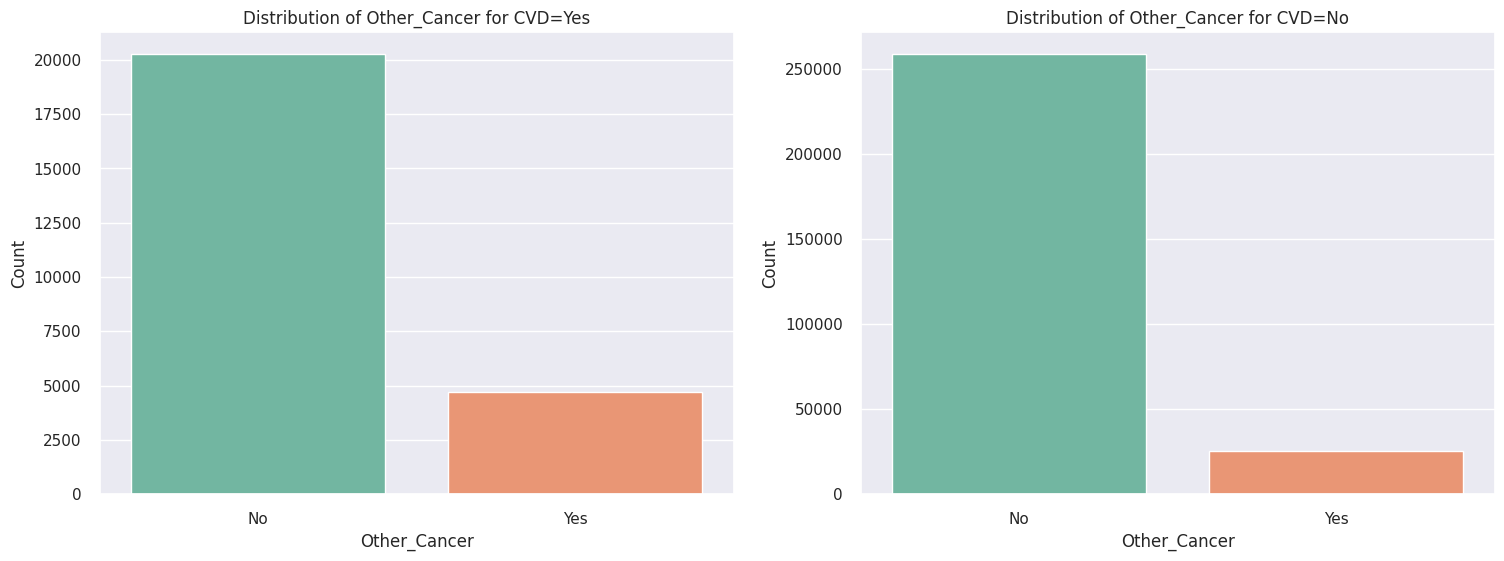

Depression


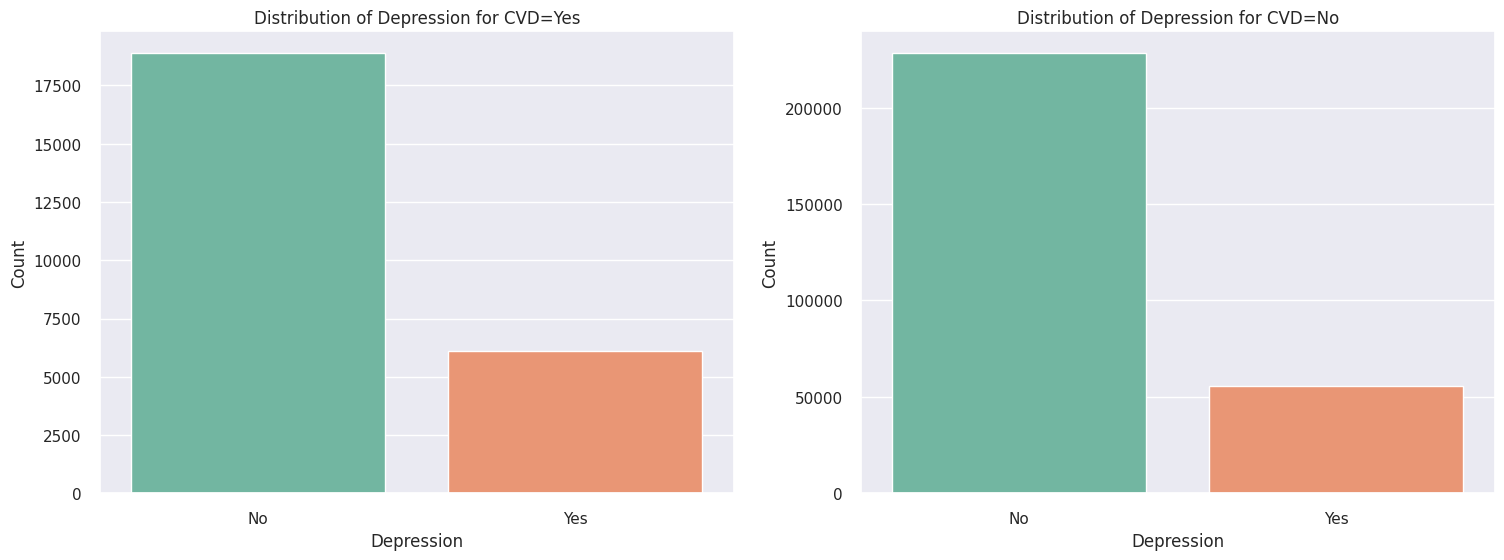

Diabetes


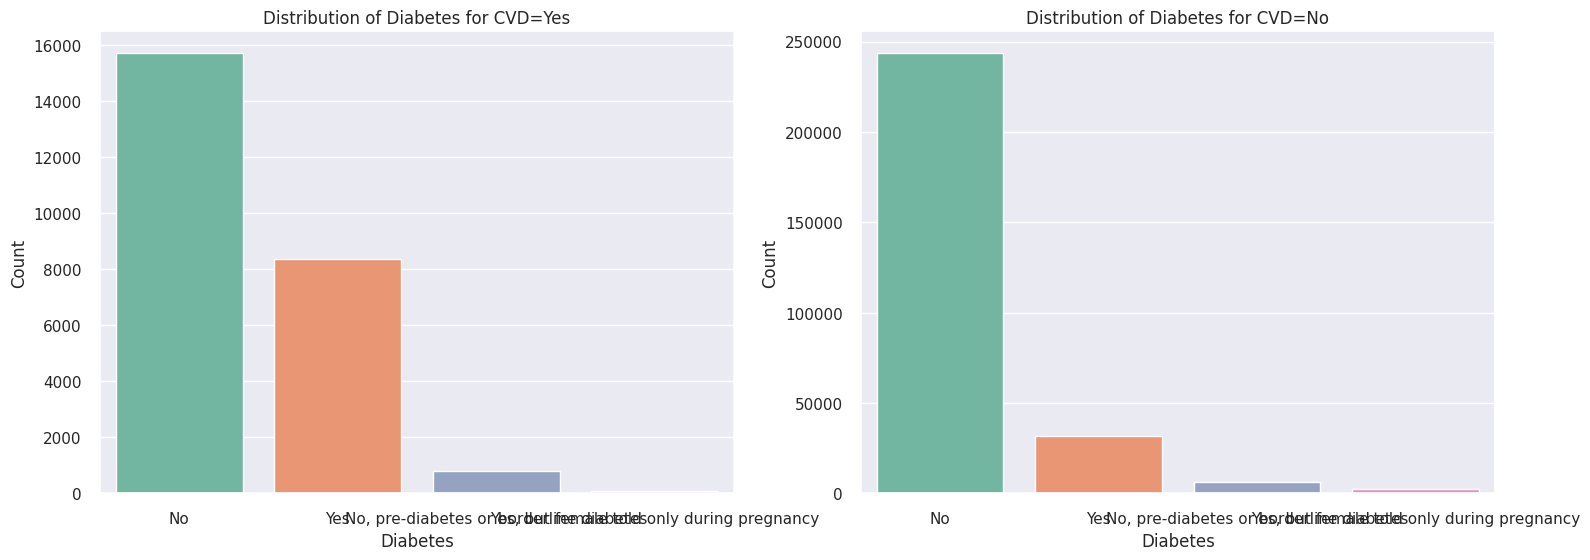

Arthritis


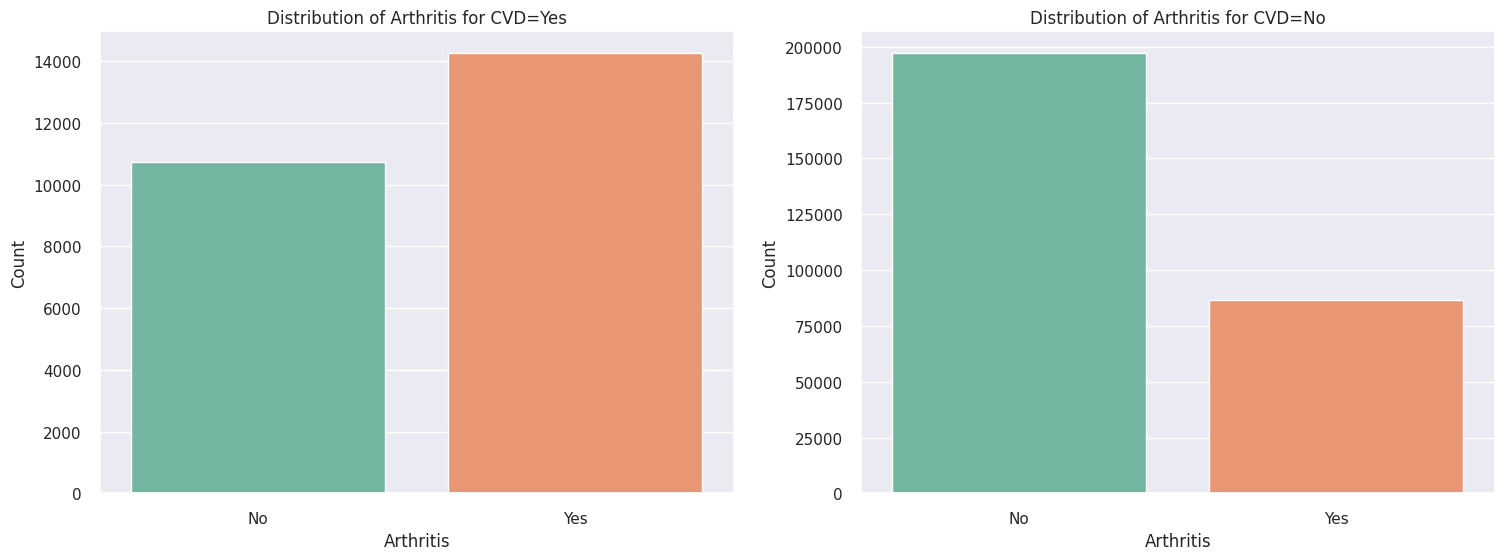

Sex


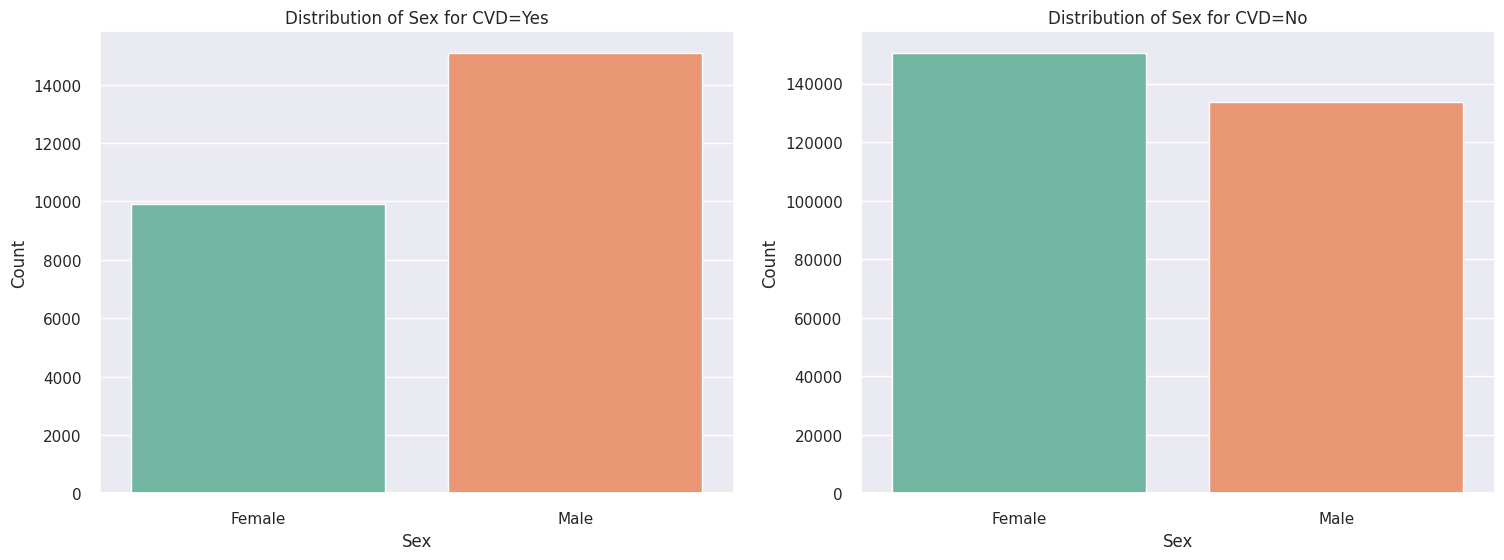

Age_Category


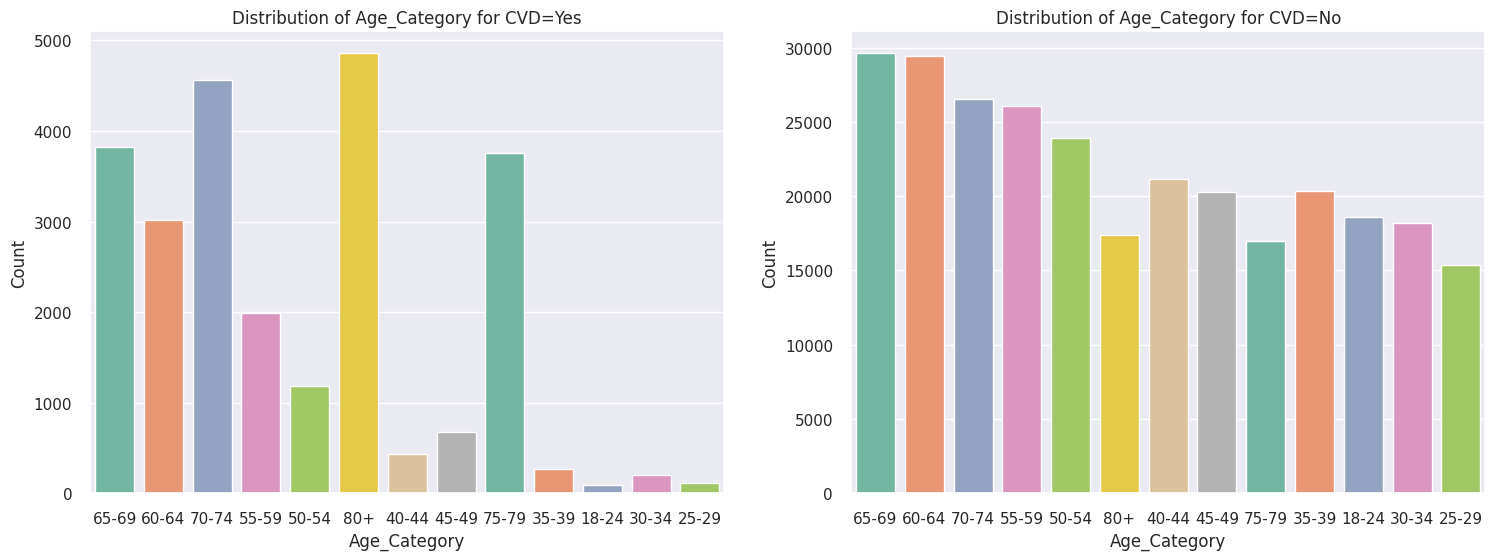

Smoking_History


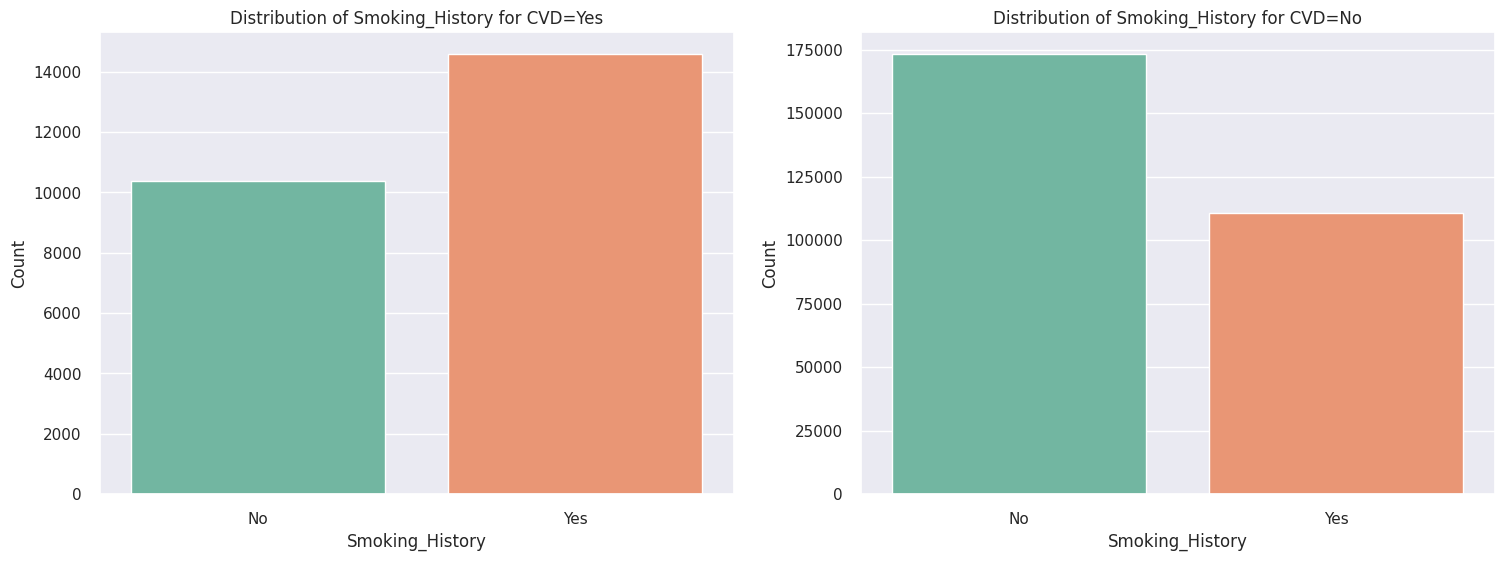

In [ ]:
for i in df.columns:

    if i == CVD:
        continue
    if i in objective:
        if df[i].nunique() > 15:
            print(f'column {i} has many unique values n = {df[i].nunique()} and will not be plotted')
            print('________________________________________________________________________________________________________________________________________________________')
            continue
        else:
          print(f'{i}')
          #each row will have two figures which are the distribution of the certain feature with regard to CVD=0 and CVD=1.
          fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
          color = 'Set2'
          for j, target_value in enumerate(['Yes', 'No']):
            ax = axes[j]
            ax = sns.countplot(x=i, data=df[df[CVD] == target_value], palette=color, order=df[i].value_counts().index, ax=ax)
            ax.set_ylabel('Count')
            ax.set_title(f'Distribution of {i} for CVD={target_value}')



        plt.show()

Check data imbalance

In [ ]:
# counting the number of instances or samples in each class.
class_counts = df[CVD].value_counts()
print(class_counts)

No     283883
Yes     24971
Name: Heart_Disease, dtype: int64


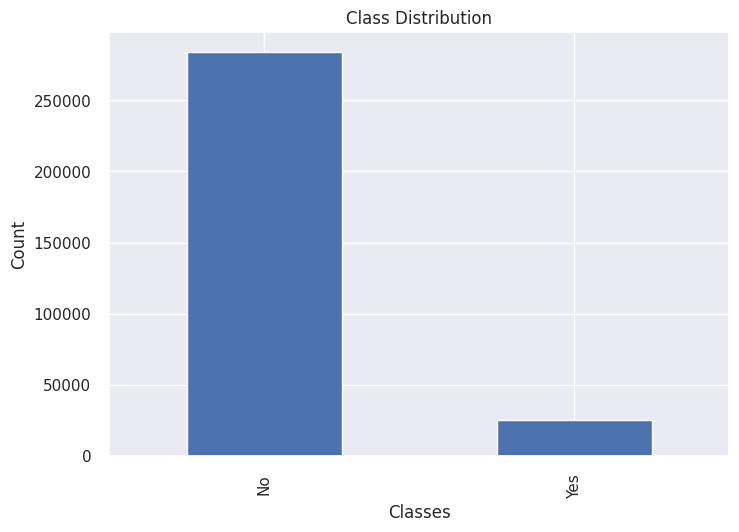

In [ ]:
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [ ]:
minority_class_count = class_counts.min()
majority_class_count = class_counts.max()
imbalance_ratio = majority_class_count / minority_class_count
print(f'Imbalance Ratio: {imbalance_ratio:.2f}')

Imbalance Ratio: 11.37


This high imbalance ratio=11.37 indicates a significant class imbalance, which should be fixed.
Let's also check the imbalance in the other categorical features.



Very Good    110395
Good          95364
Excellent     55954
Fair          35810
Poor          11331
Name: General_Health, dtype: int64


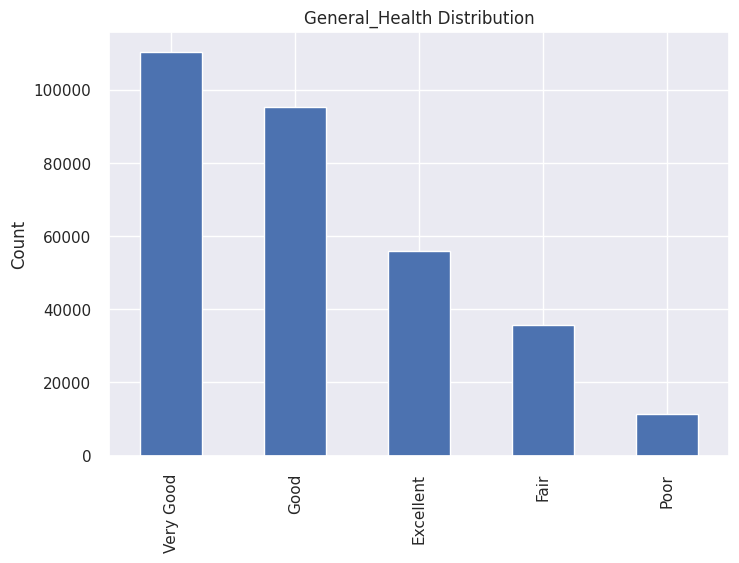

Within the past year       239371
Within the past 2 years     37213
Within the past 5 years     17442
5 or more years ago         13421
Never                        1407
Name: Checkup, dtype: int64


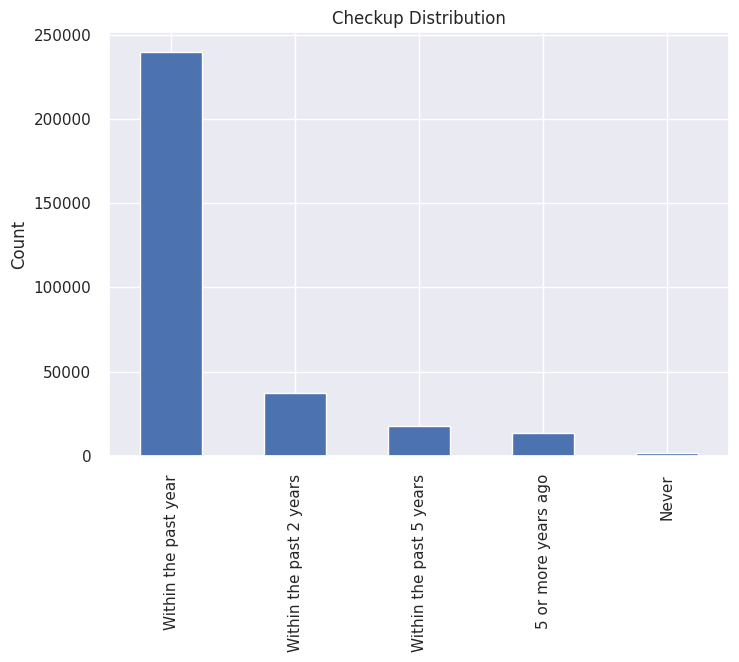

Yes    239381
No      69473
Name: Exercise, dtype: int64


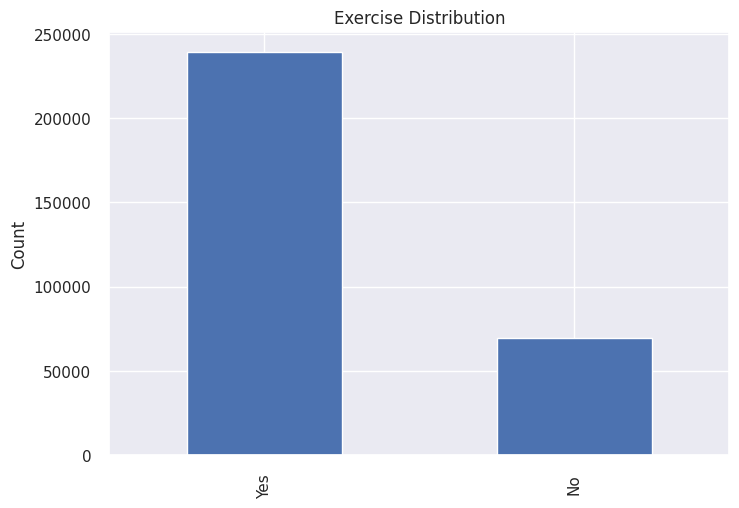

No     283883
Yes     24971
Name: Heart_Disease, dtype: int64


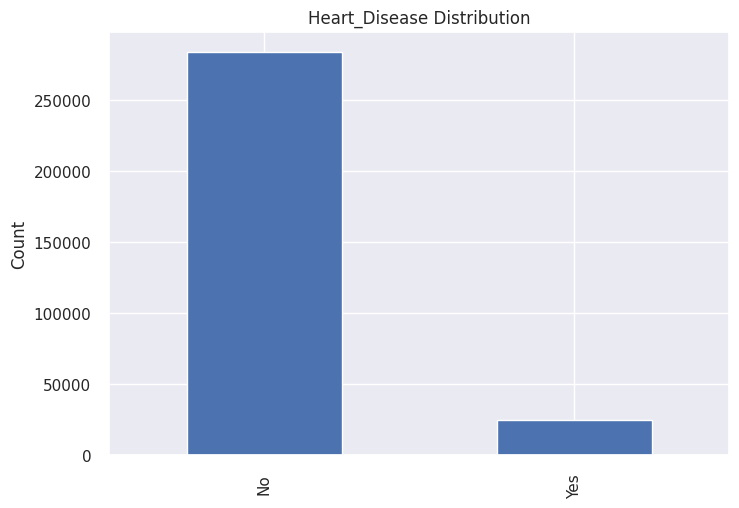

No     278860
Yes     29994
Name: Skin_Cancer, dtype: int64


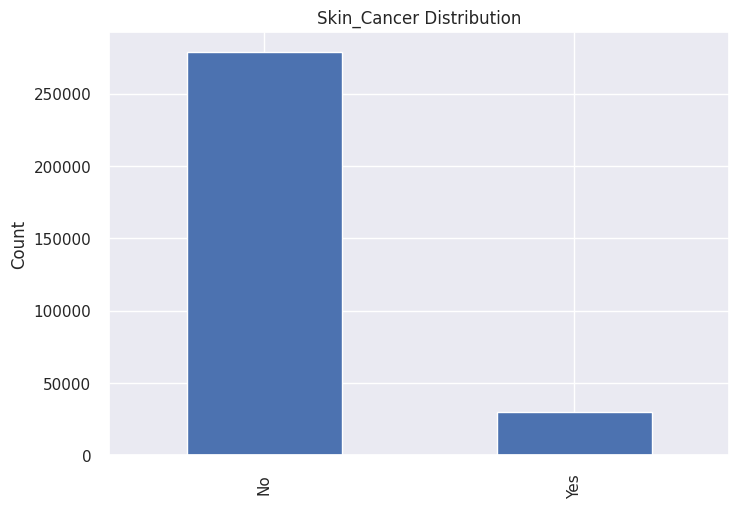

No     278976
Yes     29878
Name: Other_Cancer, dtype: int64


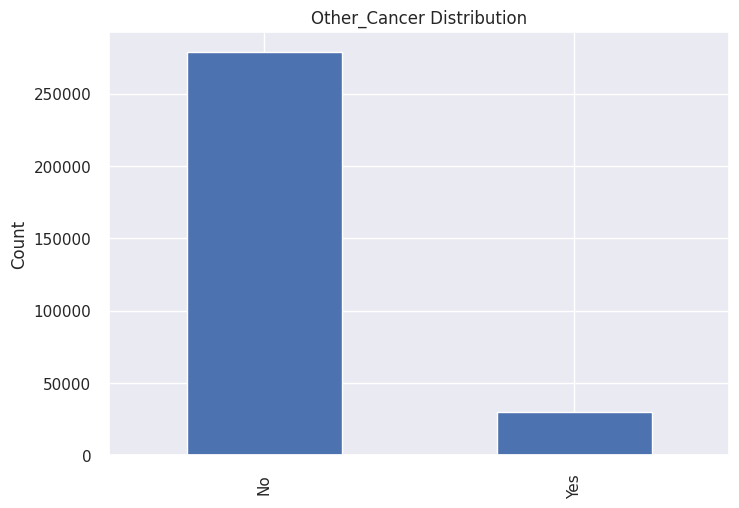

No     246953
Yes     61901
Name: Depression, dtype: int64


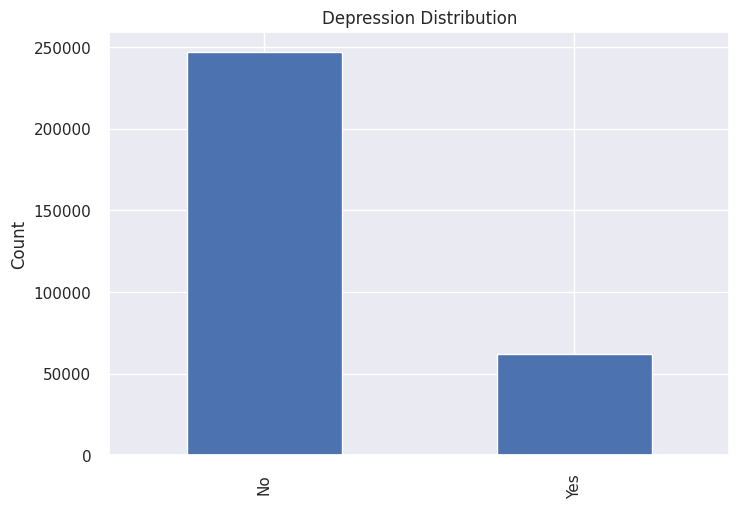

No                                            259141
Yes                                            40171
No, pre-diabetes or borderline diabetes         6896
Yes, but female told only during pregnancy      2646
Name: Diabetes, dtype: int64


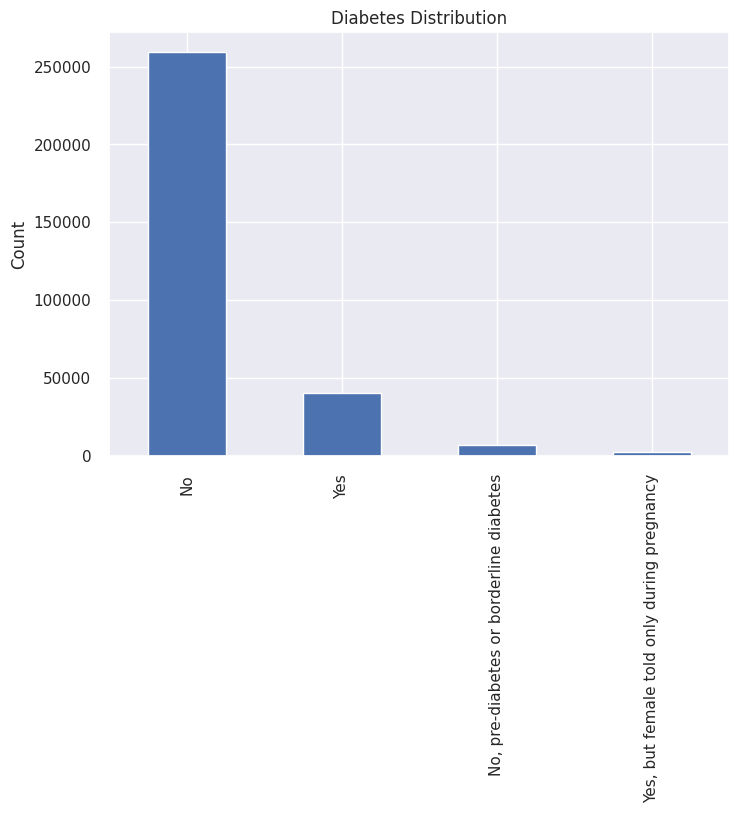

No     207783
Yes    101071
Name: Arthritis, dtype: int64


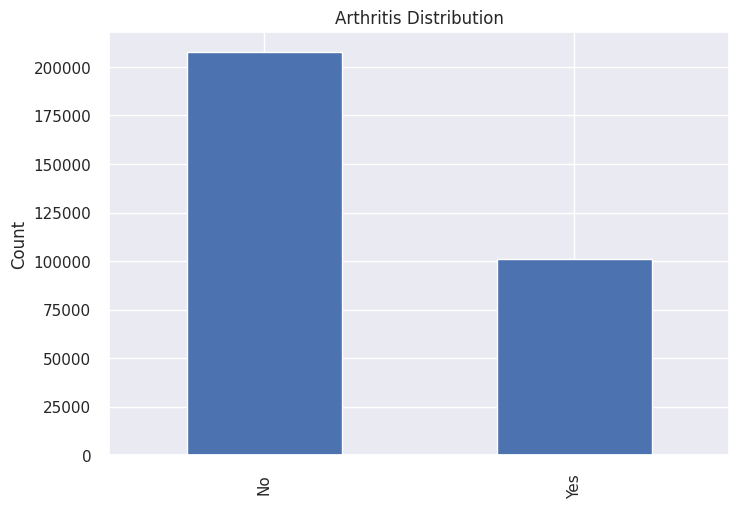

Female    160196
Male      148658
Name: Sex, dtype: int64


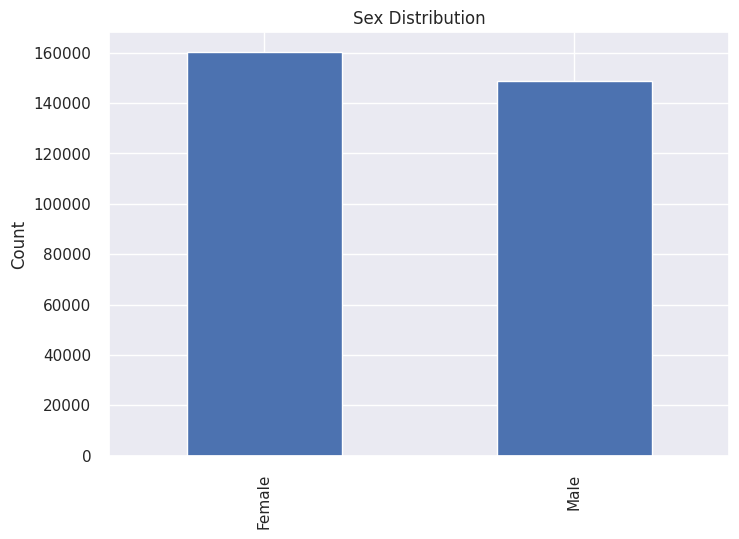

65-69    33434
60-64    32418
70-74    31103
55-59    28054
50-54    25097
80+      22271
40-44    21595
45-49    20968
75-79    20705
35-39    20606
18-24    18681
30-34    18428
25-29    15494
Name: Age_Category, dtype: int64


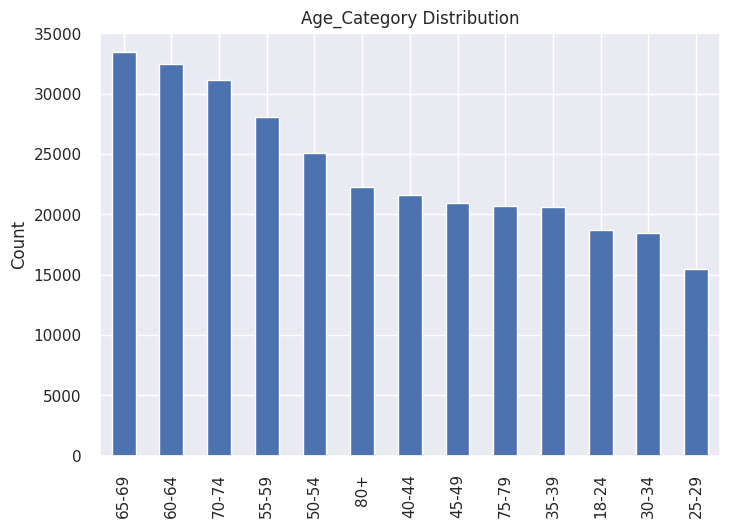

No     183590
Yes    125264
Name: Smoking_History, dtype: int64


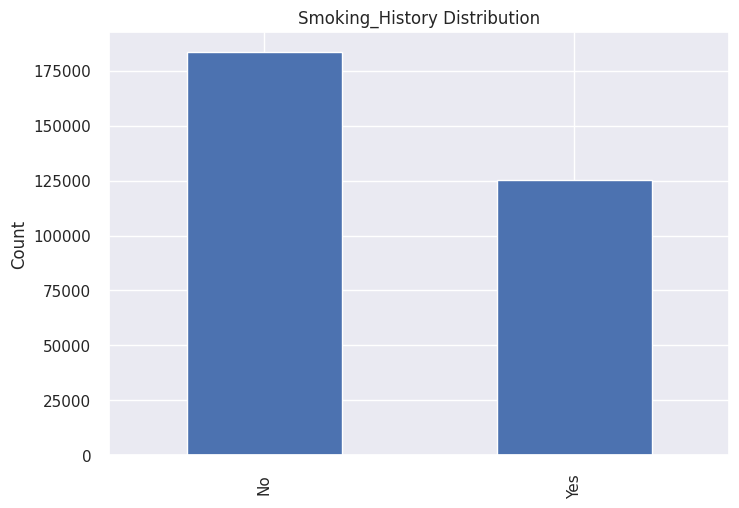

In [ ]:
# List of variables to plot imbalance
imbalanced_variable=[]
for variable in objective_data:
  class_counts = df[variable].value_counts()
  print(class_counts)
  class_counts.plot(kind='bar')
  plt.title(f'{variable} Distribution')
  plt.ylabel('Count')
  plt.show()
  minority_class_count = class_counts.min()
  majority_class_count = class_counts.max()
  imbalance_ratio = majority_class_count / minority_class_count
  if (imbalance_ratio>=8):
    imbalanced_variable.append(variable)

In [ ]:
print (imbalanced_variable)

['General_Health', 'Checkup', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Diabetes']


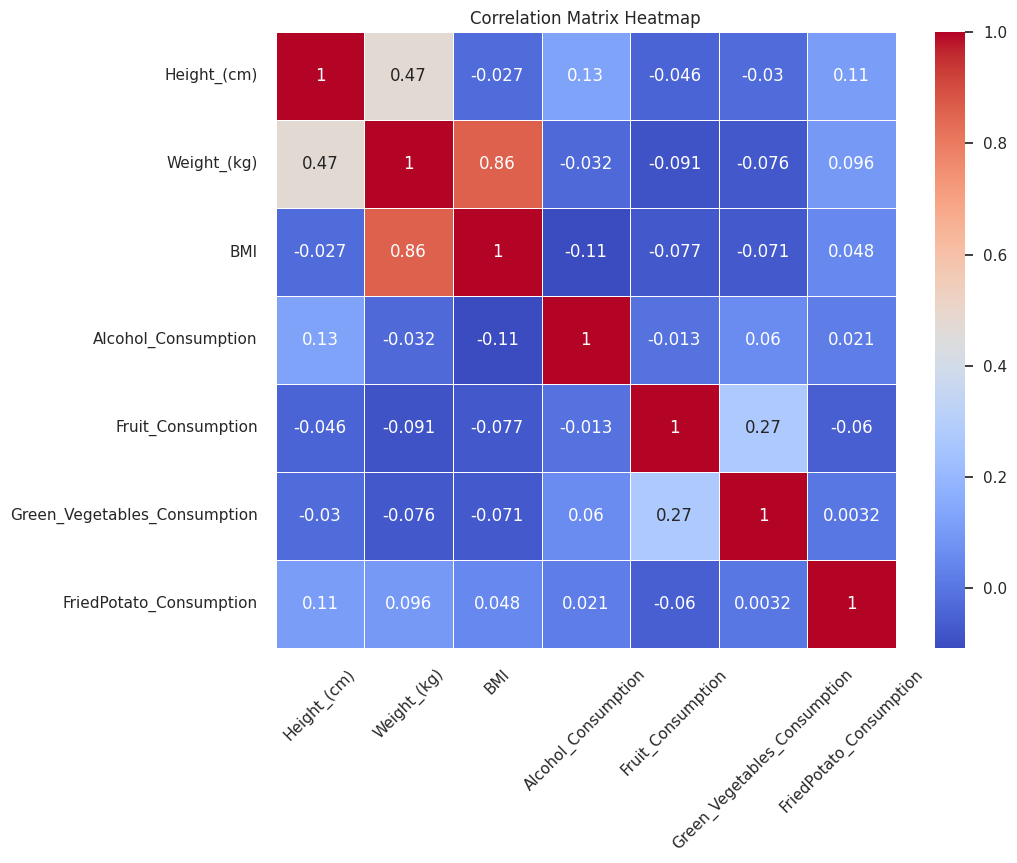

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

# Customize heatmap appearance (optional)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal

# Display the heatmap
plt.show()


Handling outliers


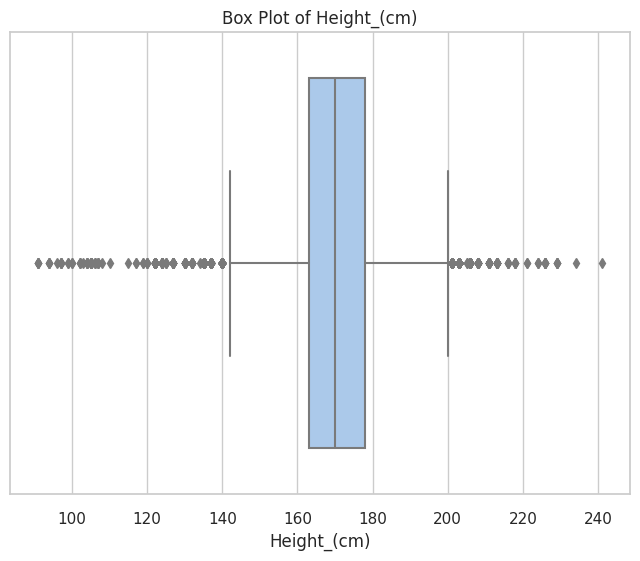

In [ ]:
# Set up the style of the plot using Seaborn
sns.set(style="whitegrid", palette='pastel')

# Create a box plot for the 'Height_(cm)' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Height_(cm)'])

# Add a title and labels
plt.title('Box Plot of Height_(cm)')
plt.xlabel('Height_(cm)')

# Show the plot
plt.show()

In [ ]:
# Calculate quartiles and IQR
Q1 = df['Height_(cm)'].quantile(0.25) #Q1 represents the 25th percentile, meaning that 25% of the data points fall below it.
Q3 = df['Height_(cm)'].quantile(0.75) #Q3 represents the 75th percentile, meaning that 75% of the data points fall below it.
IQR = Q3 - Q1 #The IQR is a measure of statistical dispersion and is calculated as the difference between the third quartile (Q3) and the first quartile (Q1): IQR = Q3 - Q1.
#The IQR is often used to identify outliers in a dataset. Data points that are below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR are considered potential outliers.
# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the outliers
outliers_count = df[(df['Height_(cm)'] < lower_bound) | (df['Height_(cm)'] > upper_bound)]['Height_(cm)'].count()
print("Lower bound is:", lower_bound)
print("Upper bound is:", upper_bound)
print("Number of outliers (theoritically) in Height_(cm):", outliers_count)

Lower bound is: 140.5
Upper bound is: 200.5
Number of outliers (theoritically) in Height_(cm): 1055


In [ ]:
# Count the number of values in 'Height_(cm)' column over 140 cm
# Count the number of values in 'Height_(cm)' column greater than 215 cm
count_less_than_130 = df[df['Height_(cm)'] < 130]['Height_(cm)'].count()
print("Number of values in Height_(cm) less than 120 cm:", count_less_than_130)
count_greater_than_215 = df[df['Height_(cm)'] > 215]['Height_(cm)'].count()
print("Number of values in Height_(cm) greater than 200 cm:", count_greater_than_215)

Number of values in Height_(cm) less than 120 cm: 165
Number of values in Height_(cm) greater than 200 cm: 29


In [ ]:
# Remove rows where height is less than 120 cm
df = df[df['Height_(cm)'] >= 130]

# Remove rows where height is greater than 220 cm
df = df[df['Height_(cm)'] <= 215]

# Print the updated DataFrame
df.shape

(308660, 19)

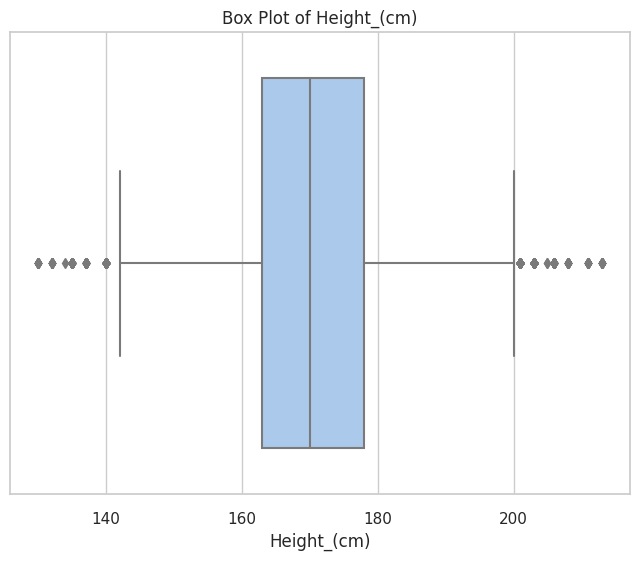

In [ ]:
# Set up the style of the plot using Seaborn
sns.set(style="whitegrid", palette='pastel')

# Create a box plot for the 'Height_(cm)' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Height_(cm)'])

# Add a title and labels
plt.title('Box Plot of Height_(cm)')
plt.xlabel('Height_(cm)')

# Show the plot
plt.show()

In [ ]:
Q1 = df['Height_(cm)'].quantile(0.25)
Q3 = df['Height_(cm)'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the outliers
outliers_count = df[(df['Height_(cm)'] < lower_bound) | (df['Height_(cm)'] > upper_bound)]['Height_(cm)'].count()

print("Number of outliers in Height_(cm):", outliers_count)

Number of outliers in Height_(cm): 861


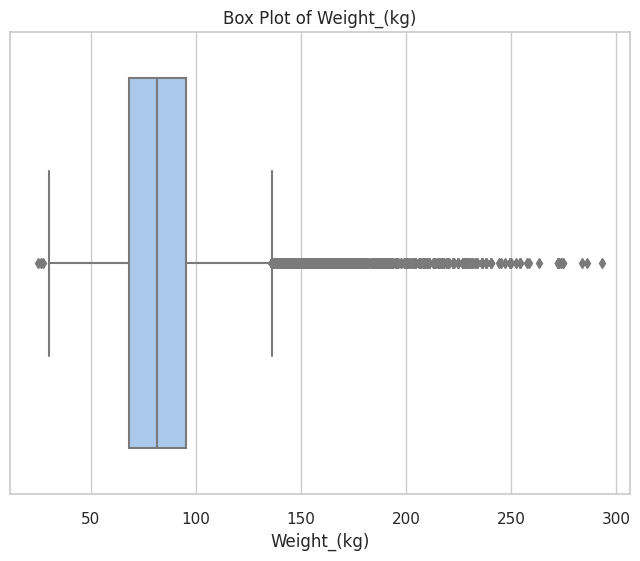

In [ ]:
#Outliers of weight
# Set up the style of the plot using Seaborn
sns.set(style="whitegrid", palette='pastel')

# Create a box plot for the 'Weight_(kg)' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Weight_(kg)'])

# Add a title and labels
plt.title('Box Plot of Weight_(kg)')
plt.xlabel('Weight_(kg)')

# Show the plot
plt.show()

In [ ]:
# Calculate quartiles and IQR
Q1 = df['Weight_(kg)'].quantile(0.25)
Q3 = df['Weight_(kg)'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the outliers
outliers_count = df[(df['Weight_(kg)'] < lower_bound) | (df['Weight_(kg)'] > upper_bound)]['Weight_(kg)'].count()

print("Number of outliers in Weight_(kg):", outliers_count)

Number of outliers in Weight_(kg): 7319


In [ ]:
count_less_than_40kg = df[df['Weight_(kg)'] < 40]['Weight_(kg)'].count()
print("Number of values in Weight_(kg) less than 40 kg:", count_less_than_40kg)
count_greater_than_200kg = df[df['Weight_(kg)'] > 200]['Weight_(kg)'].count()
print("Number of values in Weight_(kg) greater than 270 kg:", count_greater_than_200kg)

Number of values in Weight_(kg) less than 40 kg: 283
Number of values in Weight_(kg) greater than 270 kg: 219


In [ ]:
# Remove rows where weight is less than 40 kg
df = df[df['Weight_(kg)'] >= 40]

# Remove rows where weight is greater than 200 kg
df = df[df['Weight_(kg)'] <= 200]

# Print the updated DataFrame
df.shape

(308158, 19)

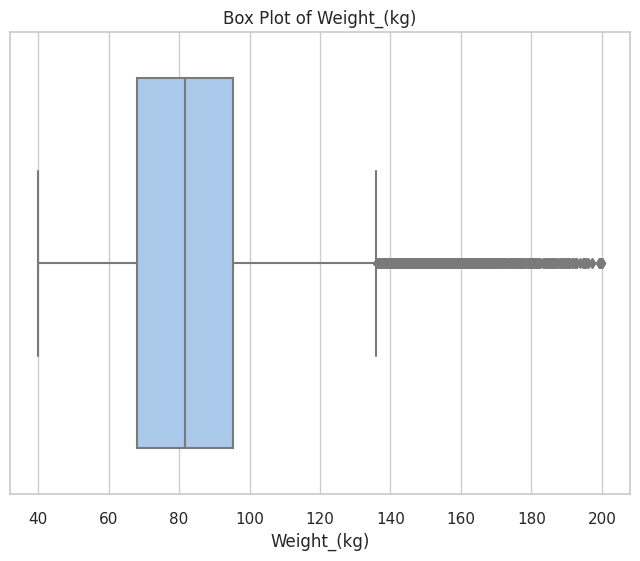

In [ ]:
# Set up the style of the plot using Seaborn
sns.set(style="whitegrid", palette='pastel')

# Create a box plot for the 'Weight_(kg)' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Weight_(kg)'])

# Add a title and labels
plt.title('Box Plot of Weight_(kg)')
plt.xlabel('Weight_(kg)')

# Show the plot
plt.show()

In [ ]:
# Calculate quartiles and IQR
Q1 = df['Weight_(kg)'].quantile(0.25)
Q3 = df['Weight_(kg)'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the outliers
outliers_count = df[(df['Weight_(kg)'] < lower_bound) | (df['Weight_(kg)'] > upper_bound)]['Weight_(kg)'].count()

print("Number of outliers in Weight_(kg):", outliers_count)

Number of outliers in Weight_(kg): 7097


Handling Duplicates

In [ ]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)

(308158, 19)
(308078, 19)


Changing the values of the target 'Heart Disease' to 0 and 1 for preprocessing steps

In [ ]:
df[CVD] = df[CVD].map({'No':0,'Yes':1})
print(df['Heart_Disease'].value_counts())

0    283169
1     24909
Name: Heart_Disease, dtype: int64


Encoding the categorical variables

In [ ]:
#we apply ordinal encoder on these categorical variables that take the values Yes or No
#For ordinal variables, the variables are transformed based on their order. The values with in the lowest order will start with 0 and increases by 1.
enc = OrdinalEncoder()
df['Exercise'] = enc.fit_transform(df[['Exercise']])
df['Skin_Cancer'] = enc.fit_transform(df[['Skin_Cancer']])
df['Other_Cancer'] = enc.fit_transform(df[['Other_Cancer']])
df['Depression'] = enc.fit_transform(df[['Depression']])
df['Sex'] = enc.fit_transform(df[['Sex']])
df['Arthritis'] = enc.fit_transform(df[['Arthritis']])
df['Smoking_History'] = enc.fit_transform(df[['Smoking_History']])

In [ ]:
rank=['Poor','Fair','Good','Very Good','Excellent']
oe = OrdinalEncoder(categories=[rank])
df['General_Health']=oe.fit_transform(df[['General_Health']])

In [ ]:
rank1=['No','No, pre-diabetes or borderline diabetes','Yes, but female told only during pregnancy','Yes']
oe1 = OrdinalEncoder(categories=[rank1])
df['Diabetes']=oe1.fit_transform(df[['Diabetes']])

In [ ]:
rank2=['Within the past year','Within the past 2 years','Within the past 5 years','5 or more years ago','Never']
oe2 = OrdinalEncoder(categories=[rank2])
df['Checkup']=oe2.fit_transform(df[['Checkup']])

In [ ]:
df['Age_Category']=df['Age_Category'].str[:2].astype(int)

In [ ]:
#check data after preprocessing
df.head(3)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
1,3.0,0.0,0.0,1,0.0,0.0,0.0,3.0,0.0,0.0,70,165.0,77.11,28.29,0.0,0.0,30.0,0.0,4.0
2,3.0,0.0,1.0,0,0.0,0.0,0.0,3.0,0.0,0.0,60,163.0,88.45,33.47,0.0,4.0,12.0,3.0,16.0
3,0.0,0.0,1.0,1,0.0,0.0,0.0,3.0,0.0,1.0,75,180.0,93.44,28.73,0.0,0.0,30.0,30.0,8.0


Splitting the train and test set.


In [ ]:
train,test = train_test_split(df, test_size=0.2,random_state=22,stratify=df['Heart_Disease'])

print(train.shape)
print(test.shape)

(246462, 19)
(61616, 19)


In [ ]:
yes = train['Heart_Disease'].value_counts()[0]/len(train['Heart_Disease'])*100
no = train['Heart_Disease'].value_counts()[1]/len(train['Heart_Disease'])*100
print('Train Set')
print(f'ratio of people with heart disease to total is {yes}')
print(f'ratio of people that dont have heart disease to total is {no}')
print('')

yes = test['Heart_Disease'].value_counts()[0]/len(test['Heart_Disease'])*100
no = test['Heart_Disease'].value_counts()[1]/len(test['Heart_Disease'])*100
print('Test Set')
print(f'ratio of people with heart disease to total is {yes}')
print(f'ratio of people that dont have heart disease to total is {no}')

Train Set
ratio of people with heart disease to total is 91.91477793736965
ratio of people that dont have heart disease to total is 8.085222062630343

Test Set
ratio of people with heart disease to total is 91.91443780836146
ratio of people that dont have heart disease to total is 8.085562191638536


In [ ]:
# Splitting the X and y variables in the train set
X_train = train.drop("Heart_Disease", axis=1)
y_train = train["Heart_Disease"].copy()

# Splitting the X and y variables in the test set
X_test = test.drop("Heart_Disease", axis=1)
y_test = test["Heart_Disease"].copy()

In [ ]:
# Apply SMOTE for oversampling to training data only
sm = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Apply Tomek links for undersampling to the resampled training data
tl = TomekLinks()
X_train_resampled_tl, y_train_resampled_tl = tl.fit_resample(X_train_resampled, y_train_resampled)

In [ ]:
num_ones = np.sum(np.array(y_train_resampled_tl) == 1)
num_zeros = np.sum(np.array(y_train_resampled_tl) == 0)

# Calculate the ratio of 1s to 0s
ratio = num_ones / num_zeros if num_zeros != 0 else np.inf  # Avoid division by zero

print(f"Number of 1s: {num_ones}")
print(f"Number of 0s: {num_zeros}")
print(f"Ratio of 1s to 0s: {ratio:.2f}")

Number of 1s: 225898
Number of 0s: 226535
Ratio of 1s to 0s: 1.00


Standardization is a preprocessing technique used to rescale the features of a dataset to have a mean of 0 and a standard deviation of 1. This process transforms the data into a standard scale, making it suitable for many machine learning algorithms.

In [ ]:
scalar = MinMaxScaler()
X_train_scaled = scalar.fit_transform(X_train_resampled_tl)
X_test_scaled = scalar.transform(X_test)

applying PCA

In [ ]:
pca = PCA(n_components=X_train_scaled.shape[1], svd_solver='randomized')
pca.fit(X_train_scaled)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

pca = PCA(n_components=num_components, svd_solver='randomized')
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Model selection

In [ ]:
exp_name = setup(data=X_train_resampled_tl, target=y_train_resampled_tl, use_gpu=True)
best_model = compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,1180
1,Target,Heart_Disease
2,Target type,Binary
3,Original data shape,"(452433, 19)"
4,Transformed data shape,"(452433, 19)"
5,Transformed train set shape,"(316703, 19)"
6,Transformed test set shape,"(135730, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9567,0.9878,0.9277,0.9847,0.9554,0.9135,0.9150,33.0070
rf,Random Forest Classifier,0.9555,0.9859,0.9191,0.9912,0.9538,0.9111,0.9135,39.1660
lightgbm,Light Gradient Boosting Machine,0.9541,0.9853,0.9110,0.9967,0.9519,0.9081,0.9115,3.6370
gbc,Gradient Boosting Classifier,0.9468,0.9834,0.9075,0.9846,0.9445,0.8935,0.8962,93.0400
ada,Ada Boost Classifier,0.9347,0.9791,0.9045,0.9624,0.9326,0.8694,0.8710,19.7270
dt,Decision Tree Classifier,0.9221,0.9221,0.9303,0.9150,0.9226,0.8442,0.8443,2.8440
knn,K Neighbors Classifier,0.8580,0.9453,0.9919,0.7822,0.8746,0.7161,0.7433,70.7610
ridge,Ridge Classifier,0.7747,0.0000,0.8246,0.7494,0.7852,0.5495,0.5523,0.3400
lda,Linear Discriminant Analysis,0.7747,0.8434,0.8246,0.7494,0.7852,0.5495,0.5523,0.8060
lr,Logistic Regression,0.7739,0.8435,0.8077,0.7561,0.7810,0.5478,0.5491,12.4790


Processing:   0%|          | 0/65 [00:00<?, ?it/s]